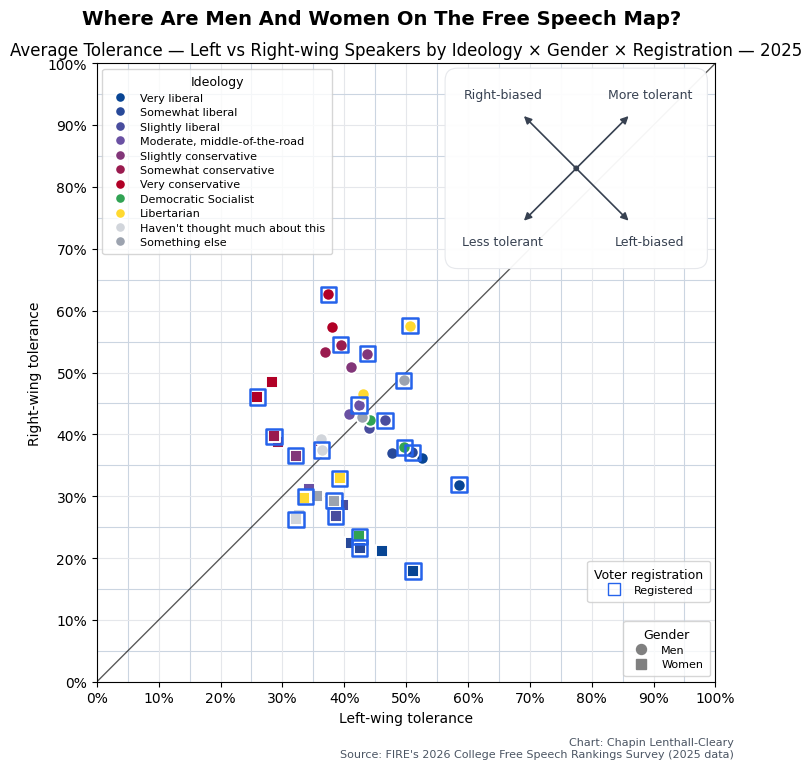

Figure saved to: /Users/chapin.lenthall-cleary/scatter_left_vs_right_avg_by_ideology_gender_reg.png


In [55]:
#!/usr/bin/env python3
"""
Scatter of average tolerance for Left- vs Right-wing speakers (x = Left, y = Right),
now binned by ideology × gender × voter registration status.

• Color = ideology (1..7) on a blue → purple (center) → red gradient
  (1 = Very liberal = blue … 4 = Moderate = purple … 7 = Very conservative = red)
• 8 = Democratic Socialist = green, 9 = Libertarian = yellow
• 10–11 in neutral grays
• Markers = gender (Men/Women)
• **Registration**: points for people **registered to vote** have **blue square boxes** around them
  (overlay outline only; the underlying marker still shows gender).
• Alternating gridlines every 5% (light gray / light-medium gray)

Adds, in the plot’s top-right, a rectangular diagonal compass whose center stays fixed.
We expand the **width only** (horizontal expansion measured in Axes fraction; 0.05 ≈ 5pp).

Compass labels (inside the box):
  ↗ More tolerant
  ↘ Left-biased
  ↖ Right-biased
  ↙ Less tolerant

Saves to:
  scatter_left_vs_right_avg_by_ideology_gender_reg.png
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch, Circle
from pathlib import Path

# --- Config ---
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

# --- Compass sizing/position (rectangular; center fixed, top-right) ---
BASE_COMPASS_W     = 0.30   # previous width  (axes fraction 0..1)
BASE_COMPASS_H     = 0.30   # previous height (axes fraction 0..1)
BASE_COMPASS_SHIFT = 0.055  # previous left shift (keeps box away from right edge)
H_EXPAND_PP        = 0.10   # expand width by ~10 percentage points of the axes

# Final rectangular size; adjust shift to keep the SAME CENTER horizontally:
# cx = 1 - pad - width/2 - shift_left  → keep cx constant as width changes
COMPASS_W     = BASE_COMPASS_W + H_EXPAND_PP
COMPASS_H     = BASE_COMPASS_H
COMPASS_SHIFT = BASE_COMPASS_SHIFT - (COMPASS_W - BASE_COMPASS_W) / 2.0

IDEO_LABELS = {
    1: "Very liberal",
    2: "Somewhat liberal",
    3: "Slightly liberal",
    4: "Moderate, middle-of-the-road",
    5: "Slightly conservative",
    6: "Somewhat conservative",
    7: "Very conservative",
    8: "Democratic Socialist",
    9: "Libertarian",
    10: "Haven't thought much about this",
    11: "Something else",
}

# Triads
RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]          # "Right-wing Speakers"
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]  # "Left-wing Speakers"
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD


def scale_triad_to_pct(sum_vals, k=3):
    """Maps triad sum (k..4k) to 0..100%."""
    return (sum_vals - k) / (3 * k) * 100.0


def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    """
    Build ideology 1..11 with preference order:
      • fire_ideo → cp_ideo → ideo
    """
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")

    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)

    ideo = np.where(valid_fire, fire,
             np.where(valid_cp, cp,
             np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")


def add_diagonal_compass(ax, *, width, height, pad=0.02, shift_left):
    """
    Draw a diagonal compass INSIDE the axes using a rectangular box.
    `width` and `height` are in Axes fraction units (0..1).
    Center remains fixed based on (width, height, shift_left, pad).

    Labels (inside the box):
      ↗ More tolerant
      ↘ Left-biased
      ↖ Right-biased
      ↙ Less tolerant
    """
    # Fixed center location with given width/height
    cx = 1 - pad - width / 2 - shift_left
    cy = 1 - pad - height / 2

    # Background box
    box = FancyBboxPatch(
        (cx - width/2, cy - height/2), width, height,
        transform=ax.transAxes, boxstyle="round,pad=0.012,rounding_size=0.02",
        linewidth=0.8, facecolor="white", edgecolor="#e5e7eb", alpha=0.95, zorder=5
    )
    ax.add_patch(box)

    # Margins and geometry for arrows/labels
    hx, hy = width / 2.0, height / 2.0
    m = min(width, height) * 0.05  # proportional inner margin

    def r_max(theta):
        """Max radius from center to stay inside rectangle minus margin."""
        ct, st = abs(np.cos(theta)), abs(np.sin(theta))
        ct = max(ct, 1e-9); st = max(st, 1e-9)
        return min((hx - m) / ct, (hy - m) / st)

    color = "#374151"
    lw = 1.2
    ms = 11
    fz = 9.0

    directions = [
        ( 45, "More tolerant"),  # NE
        (-45, "Left-biased"),    # SE
        (135, "Right-biased"),   # NW
        (225, "Less tolerant"),  # SW
    ]

    for angle_deg, label in directions:
        th = np.deg2rad(angle_deg)
        rmax = r_max(th)
        r_arrow = rmax * 0.65
        r_label = rmax * 0.88

        x_tip = cx + r_arrow * np.cos(th)
        y_tip = cy + r_arrow * np.sin(th)
        ax.add_patch(FancyArrowPatch(
            (cx, cy), (x_tip, y_tip),
            transform=ax.transAxes, arrowstyle="-|>", mutation_scale=ms,
            linewidth=lw, color=color, zorder=6
        ))

        ax.text(
            cx + r_label * np.cos(th),
            cy + r_label * np.sin(th),
            label, transform=ax.transAxes,
            ha="center", va="center", fontsize=fz, color=color, zorder=7
        )

    ax.add_patch(Circle((cx, cy), radius=min(width, height) * 0.012,
                        transform=ax.transAxes, color=color, zorder=7))


def make_ideo_gender_reg_scatter(df: pd.DataFrame, year: int):
    """
    df: already filtered to year, gender=={1,2}, ideo in 1..11, regvoter in {0,1}, all six spk_* in [1,4]
    """
    df = df.copy()

    # Triad sums & scale to percent (0..100)
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    # Group means and sizes — now includes regvoter
    stats = (df.groupby(["ideo", "gender_bin", "regvoter"], dropna=True)
               .agg(left_avg=("left_pct", "mean"),
                    right_avg=("right_pct", "mean"),
                    n=("left_pct", "size"))
               .reset_index())
    if stats.empty:
        raise SystemExit("No groups to plot after filtering—check data/filtering.")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8.8, 8.6))

    # Blue → Purple (center) → Red; center aligns at ideo=4 when sampling 7 steps
    cmap_lr = LinearSegmentedColormap.from_list(
        "blue_purple_red",
        ["#084594", "#6a51a3", "#b10026"]  # deep blue, purple midpoint, deep red
    )
    steps7 = np.linspace(0, 1, 7)
    ideology_colors = {i: cmap_lr(steps7[i - 1]) for i in range(1, 8)}
    ideology_colors.update({
        8: "#31a354",   # Democratic Socialist = green
        9: "#ffd92f",   # Libertarian = yellow
        10: "#d1d5db",  # Haven't thought much = light gray
        11: "#9ca3af",  # Something else = medium gray
    })

    # Markers for gender
    gender_markers = {1: "o", 2: "s"}  # Men = circle, Women = square

    # Alternating 5% gridlines (light / light-medium gray)
    light_gray, medium_gray = "#e5e7eb", "#cbd5e1"
    for v in range(0, 101, 5):
        ax.axhline(v, color=(light_gray if (v // 5) % 2 == 0 else medium_gray), linewidth=0.8, zorder=0)
        ax.axvline(v, color=(light_gray if (v // 5) % 2 == 0 else medium_gray), linewidth=0.8, zorder=0)

    # Base point size and overlay size for "registered" boxes
    base_size = 80
    box_size  = 120  # slightly larger to frame the point

    # Plot each point (one per ideo × gender × regvoter)
    for _, row in stats.iterrows():
        i  = int(row["ideo"])
        g  = int(row["gender_bin"])
        rv = int(row["regvoter"])
        x, y = row["left_avg"], row["right_avg"]

        # Underlying point colored by ideology, marker by gender
        ax.scatter(
            x, y,
            s=base_size,
            c=[ideology_colors.get(i, "#9ca3af")],
            marker=gender_markers.get(g, "o"),
            edgecolor="white",
            linewidth=1.4,
            zorder=3
        )

        # If registered, overlay a BLUE square outline as a "box" around the point
        if rv == 1:
            ax.scatter(
                x, y,
                s=box_size,
                facecolors="none",
                edgecolors="#2563eb",   # blue box
                linewidths=1.8,
                marker="s",             # square outline regardless of gender marker
                zorder=4
            )

    # Axes, labels, formatting
    ax.set_title(f"Average Tolerance — Left vs Right-wing Speakers by Ideology × Gender × Registration — {year}")
    ax.set_xlabel("Left-wing tolerance")
    ax.set_ylabel("Right-wing tolerance")
    ax.set_xlim(0, 100); ax.set_ylim(0, 100)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks(range(0, 101, 10)); ax.set_yticks(range(0, 101, 10))

    # Diagonal parity line
    ax.plot([0, 100], [0, 100], color="black", linewidth=1, alpha=0.65, zorder=1.5)

    # >>> Rectangular compass — horizontally expanded only; center fixed <<<
    add_diagonal_compass(ax, width=COMPASS_W, height=COMPASS_H, pad=0.02, shift_left=COMPASS_SHIFT)

    # Legends
    ideo_handles = [
        Line2D([0], [0], marker="o", linestyle="",
               markerfacecolor=ideology_colors[i], markeredgecolor="white", markersize=8,
               label=IDEO_LABELS[i])
        for i in range(1, 12)
    ]
    gender_handles = [
        Line2D([0], [0], marker=gender_markers[1], linestyle="", color="gray", label="Men", markersize=8),
        Line2D([0], [0], marker=gender_markers[2], linestyle="", color="gray", label="Women", markersize=8),
    ]
    reg_handles = [
        Line2D([0], [0],
               marker="s", linestyle="",
               markerfacecolor="none", markeredgecolor="#2563eb", markersize=9,
               label="Registered"),
        # Not registered has no box; no handle needed
    ]

    leg1 = ax.legend(
        handles=ideo_handles, title="Ideology", loc="upper left", frameon=True,
        fontsize=8, title_fontsize=9, markerscale=0.9, borderpad=0.6, labelspacing=0.4
    )
    ax.add_artist(leg1)

    leg2 = ax.legend(
        handles=gender_handles, title="Gender", loc="lower right", frameon=True,
        fontsize=8, title_fontsize=9, markerscale=0.9, borderpad=0.6, labelspacing=0.4
    )
    ax.add_artist(leg2)

    # Put registration legend near lower right, slightly above the edge
    ax.legend(
        handles=reg_handles, title="Voter registration", loc="lower right",
        bbox_to_anchor=(1.0, 0.12), frameon=True,
        fontsize=8, title_fontsize=9, borderpad=0.6, labelspacing=0.4
    )

    # New headline above the existing title (closer to the plot)
    fig.suptitle(
        "Where Are Men And Women On The Free Speech Map?",
        fontsize=14, fontweight="bold", y=0.9
    )

    # Credits in the bottom-right corner (pulled up closer to the plot)
    fig.text(
        0.9, 0.028,
        "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
        ha="right", va="bottom", fontsize=8, color="#4b5563"
    )

    # Leave room for the titles/credits while keeping axes size effectively unchanged
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.92])

    out_path = Path("scatter_left_vs_right_avg_by_ideology_gender_reg.png")
    fig.savefig(out_path, dpi=150)
    plt.show()
    print(f"Figure saved to: {out_path.resolve()}")


def main():
    # Load
    df = pd.read_csv(CSV_PATH, low_memory=False)

    # Coerce relevant columns to numeric (now includes regvoter)
    for col in ["datayear", "gender_bin", "regvoter", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Build ideology
    df["ideo"] = build_ideo_like_code(df)

    # Filter to target year, men/women only, ideology 1..11, and regvoter in [0,1]
    df = df[
        (df["datayear"] == YEAR)
        & (df["gender_bin"].isin([1, 2]))
        & (df["ideo"].isin(range(1, 12)))
        & (df["regvoter"].isin([0, 1]))
    ]
    if df.empty:
        raise SystemExit(f"No rows found for datayear == {YEAR}, genders in [1,2], ideo in 1..11, regvoter in [0,1].")

    # Require ALL six spk_* in [1,4]
    in_range = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range.all(axis=1)].copy()
    if df.empty:
        raise SystemExit("No rows remain after requiring all six spk_* to be in [1,4].")

    make_ideo_gender_reg_scatter(df, YEAR)


if __name__ == "__main__":
    main()



=== All ages (Men & Women) ===

Sample size by registration — Men
Registration status     N
     Not registered  5064
         Registered 19350

Δ (Left, Right) — Men — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,6.03,-4.33,7.42,311,2172
1,2,Somewhat liberal,3.34,0.03,3.34,662,3221
2,3,Slightly liberal,2.55,1.29,2.85,518,2146
3,4,"Moderate, middle-of-the-road",1.63,1.40,2.15,1015,3126
4,5,Slightly conservative,2.66,2.18,3.44,445,1718
5,6,Somewhat conservative,2.54,1.14,2.79,527,2746
6,7,Very conservative,-0.55,5.23,5.26,195,1453
7,8,Democratic Socialist,5.55,-4.32,7.04,168,473
8,9,Libertarian,7.54,10.98,13.32,108,285
9,10,Haven't thought much about this,0.16,-1.80,1.80,884,1487


Saved: vectors_left_right_NotToRegistered_Men_2025.png


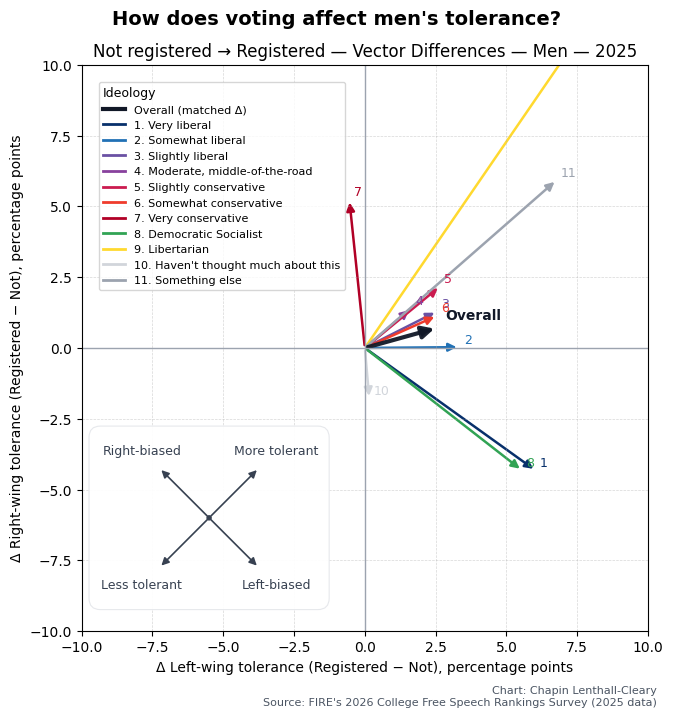


Sample size by registration — Women
Registration status     N
     Not registered  6340
         Registered 34476

Δ (Left, Right) — Women — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,4.97,-3.19,5.90,671,7630
1,2,Somewhat liberal,1.41,-0.82,1.63,1340,9927
2,3,Slightly liberal,-1.12,-1.80,2.12,706,3523
3,4,"Moderate, middle-of-the-road",-0.70,-1.31,1.48,1055,4200
4,5,Slightly conservative,-4.10,-2.45,4.78,333,1548
5,6,Somewhat conservative,-0.61,0.92,1.11,437,2687
6,7,Very conservative,-2.40,-2.40,3.39,169,1619
7,8,Democratic Socialist,10.13,-2.79,10.50,195,658
8,9,Libertarian,5.82,3.12,6.60,109,270
9,10,Haven't thought much about this,-0.46,-0.73,0.86,1068,1825


Saved: vectors_left_right_NotToRegistered_Women_2025.png


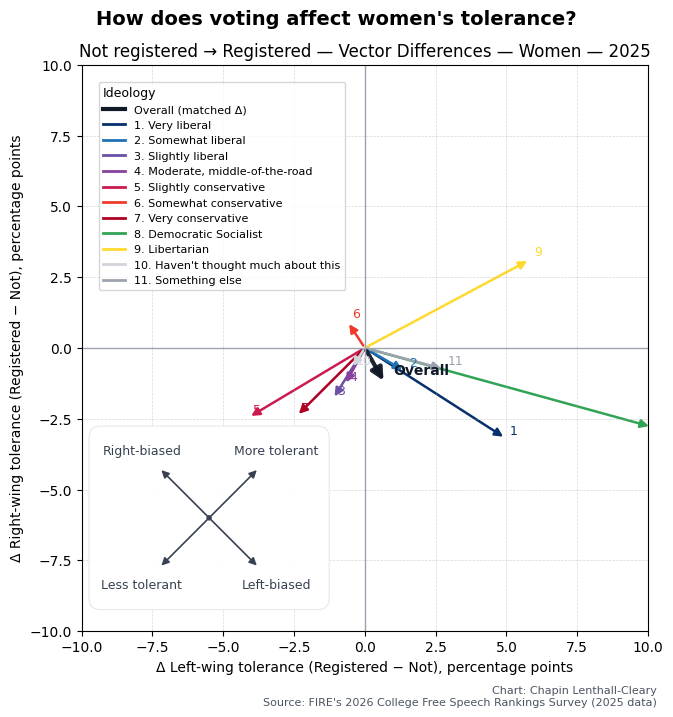

In [56]:
#!/usr/bin/env python3
"""
Vector plots comparing voter-registration groups using the Left vs Right tolerance axes.

We draw TWO square vector figures per YEAR (all ages):
  1) Men:   Not registered → Registered
  2) Women: Not registered → Registered

Each vector (per ideology) represents:
  X = Δ Left-wing tolerance (Registered − Not registered), percentage points
  Y = Δ Right-wing tolerance (Registered − Not registered), percentage points
Plus a bold pooled “Overall” arrow.

IMPORTANT (Estimator for the Overall arrow):
  This version uses the matched-delta estimator:
    • Compute per-ideology deltas only for ideologies that have BOTH registration statuses.
    • Pool deltas with weights w_i = min(n_i_base, n_i_target).
  (Replaces the old "difference of weighted means" approach.)

We also print count tables (N) by voter registration for each gender,
and the per-ideology Ns used for the deltas.

Adds a rectangular diagonal **compass** (like Code 2) inside each plot,
but positioned in the **bottom-left** corner with the SAME CENTER even if the
compass width expands horizontally.

Inputs
------
- cfsrALL_24_25.csv (same as your other scripts)

Outputs
-------
- vectors_left_right_NotToRegistered_Men_YYYY.png
- vectors_left_right_NotToRegistered_Women_YYYY.png

Usage
-----
- Ensure cfsrALL_24_25.csv is next to this file
- Adjust YEAR if needed
- Run: python vector_plots_registration_deltas_allages.py
"""

from pathlib import Path
from typing import Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch, Circle
from matplotlib.lines import Line2D

# ---------- Settings ----------
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

# ---------- Compass sizing/position (rectangular; center fixed) ----------
BASE_COMPASS_W         = 0.30
BASE_COMPASS_H         = 0.30
BASE_COMPASS_SHIFT_R   = 0.055
BASE_COMPASS_SHIFT_UP  = 0.030   # ↓ moved down a bit (was 0.055)
H_EXPAND_FRAC          = 0.10

COMPASS_W         = BASE_COMPASS_W + H_EXPAND_FRAC
COMPASS_H         = BASE_COMPASS_H
COMPASS_SHIFT_R   = BASE_COMPASS_SHIFT_R - (COMPASS_W - BASE_COMPASS_W) / 2.0
COMPASS_SHIFT_UP  = BASE_COMPASS_SHIFT_UP


# ---------- Labels & triads ----------
IDEO_LABELS = {
    1: "Very liberal",
    2: "Somewhat liberal",
    3: "Slightly liberal",
    4: "Moderate, middle-of-the-road",
    5: "Slightly conservative",
    6: "Somewhat conservative",
    7: "Very conservative",
    8: "Democratic Socialist",
    9: "Libertarian",
    10: "Haven't thought much about this",
    11: "Something else",
}

REGVOTER_LABELS = {
    0: "Not registered",
    1: "Registered",
}

RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

# ---------- Colors (ideology-coded) ----------
def ideology_colors() -> Dict[int, str]:
    return {
        1: "#08306b",  # deep navy
        2: "#2171b5",  # blue
        3: "#6a51a3",  # strong purple
        4: "#88419d",  # mid purple
        5: "#cb1b4f",  # magenta-red
        6: "#ef3b2c",  # bright red
        7: "#b10026",  # deep red
        8: "#31a354",  # green
        9: "#ffd92f",  # yellow
        10: "#d1d5db", # light gray
        11: "#9ca3af", # darker gray
    }
IDEO_COLORS = ideology_colors()

# ---------- Helpers ----------
def scale_triad_to_pct(sum_vals: pd.Series, k: int = 3) -> pd.Series:
    """Maps triad sum (k..4k) to 0..100%."""
    return (sum_vals - k) / (3 * k) * 100.0


def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    """Build ideology 1..11 with preference order: fire_ideo → cp_ideo → ideo."""
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")
    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)
    ideo = np.where(valid_fire, fire, np.where(valid_cp, cp, np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")


def load_and_filter(csv_path: Path, year: int) -> pd.DataFrame:
    """
    Load CSV, coerce numerics, build ideology, and apply base filters.
    (All ages — no age filtering.)
    """
    if not csv_path.exists():
        raise FileNotFoundError(f"Data file not found at: {csv_path.resolve()}")

    df = pd.read_csv(csv_path, low_memory=False)

    # Coerce relevant columns to numeric
    for col in ["datayear", "gender_bin", "regvoter", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Build ideology
    df["ideo"] = build_ideo_like_code(df)

    # Base filters: year, gender, ideology, regvoter (0/1)
    df = df[
        (df["datayear"] == year)
        & (df["gender_bin"].isin([1, 2]))
        & (df["regvoter"].isin([0, 1]))
        & (df["ideo"].isin(range(1, 12)))
    ].copy()
    if df.empty:
        raise ValueError(
            f"No rows after filtering for year={year}, gender in [1,2], regvoter in [0,1], and ideo in 1..11."
        )

    # Require ALL six spk_* in [1,4]
    in_range_spk = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range_spk.all(axis=1)].copy()
    if df.empty:
        raise ValueError("No rows remain after requiring spk_* in [1,4].")

    # Triad sums & scale to percent (0..100)
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    return df


def compute_group_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group means (ideology × gender × regvoter) for left/right tolerance, with Ns.
    Returns columns: ideo, gender_bin, regvoter, left_avg, right_avg, n
    """
    stats = (
        df.groupby(["ideo", "gender_bin", "regvoter"], dropna=True)
          .agg(left_avg=("left_pct", "mean"),
               right_avg=("right_pct", "mean"),
               n=("left_pct", "size"))
          .reset_index()
    )
    return stats


def prepare_deltas_for_gender(
    stats: pd.DataFrame,
    gender_code: int,
    base_reg: int = 0,   # Not registered
    target_reg: int = 1  # Registered
) -> pd.DataFrame:
    """
    For a given gender, compute ideology-wise deltas:
      Δx = left_avg(target) − left_avg(base)
      Δy = right_avg(target) − right_avg(base)
    Keep ideologies where both groups exist.
    Also include n_base and n_target for transparency.
    """
    s = stats[stats["gender_bin"] == gender_code].copy()
    if s.empty:
        return pd.DataFrame(columns=[
            "ideo", "Ideology label", "delta_x", "delta_y", "magnitude",
            "n_base", "n_target"
        ])

    x_pivot = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    y_pivot = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_pivot = s.pivot(index="ideo", columns="regvoter", values="n")

    df = pd.DataFrame({
        "delta_x":  x_pivot.get(target_reg) - x_pivot.get(base_reg),
        "delta_y":  y_pivot.get(target_reg) - y_pivot.get(base_reg),
        "n_base":   n_pivot.get(base_reg),
        "n_target": n_pivot.get(target_reg),
    }).dropna().reset_index()

    df["ideo"] = df["ideo"].astype(int)
    df["Ideology label"] = df["ideo"].map(IDEO_LABELS)
    df["magnitude"] = np.sqrt(df["delta_x"]**2 + df["delta_y"]**2)

    return df[["ideo", "Ideology label", "delta_x", "delta_y", "magnitude", "n_base", "n_target"]].sort_values("ideo")


def compute_overall_delta_for_gender(
    stats: pd.DataFrame,
    gender_code: int,
    base_reg: int = 0,
    target_reg: int = 1
) -> dict | None:
    """
    Matched-delta overall arrow for a gender:
      • Compute per-ideology deltas only for ideologies that have BOTH reg statuses.
      • Pool deltas with weights w_i = min(n_i_base, n_i_target).
    Returns dict with delta_x, delta_y, n_base, n_target or None if unavailable.
    """
    s = stats[stats["gender_bin"] == gender_code]
    if s.empty:
        return None

    # Pivots
    x_pivot = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    y_pivot = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_pivot = s.pivot(index="ideo", columns="regvoter", values="n")

    # Need both statuses present
    for p in (x_pivot, y_pivot, n_pivot):
        if base_reg not in p.columns or target_reg not in p.columns:
            return None

    x_pair = x_pivot[[base_reg, target_reg]].dropna()
    y_pair = y_pivot[[base_reg, target_reg]].dropna()
    n_pair = n_pivot[[base_reg, target_reg]].dropna()

    common = x_pair.index.intersection(y_pair.index).intersection(n_pair.index)
    if len(common) == 0:
        return None

    dx = (x_pair.loc[common, target_reg] - x_pair.loc[common, base_reg]).astype(float)
    dy = (y_pair.loc[common, target_reg] - y_pair.loc[common, base_reg]).astype(float)
    w  = np.minimum(n_pair.loc[common, base_reg], n_pair.loc[common, target_reg]).astype(float)

    mask = (w > 0) & dx.notna() & dy.notna()
    if not mask.any():
        return None

    sel = w.index[mask]
    delta_x = float(np.average(dx.loc[sel], weights=w.loc[sel]))
    delta_y = float(np.average(dy.loc[sel], weights=w.loc[sel]))

    return {
        "delta_x":  delta_x,
        "delta_y":  delta_y,
        "n_base":   int(n_pair.loc[sel, base_reg].sum()),
        "n_target": int(n_pair.loc[sel, target_reg].sum()),
    }

# ---------- Compass (bottom-left, rectangular; center fixed) ----------
def add_diagonal_compass_bottom_left(ax, *, width, height, pad=0.02, shift_right=0.0, shift_up=0.0):
    """
    Draw a diagonal compass INSIDE the axes using a rectangular box in the **bottom-left**.
    `width` and `height` are in Axes fraction units (0..1).

    We keep the horizontal center fixed when width changes by adjusting `shift_right`:
      cx = pad + width/2 + shift_right   (constant when width varies if shift_right changes accordingly)
      cy = pad + height/2 + shift_up

    Labels (inside the box):
      ↗ More tolerant
      ↘ Left-biased
      ↖ Right-biased
      ↙ Less tolerant
    """
    # Fixed center location with given width/height
    cx = pad + width / 2.0 + shift_right
    cy = pad + height / 2.0 + shift_up

    # Background box
    box = FancyBboxPatch(
        (cx - width/2, cy - height/2), width, height,
        transform=ax.transAxes, boxstyle="round,pad=0.012,rounding_size=0.02",
        linewidth=0.8, facecolor="white", edgecolor="#e5e7eb", alpha=0.95, zorder=5
    )
    ax.add_patch(box)

    # Margins and geometry for arrows/labels
    hx, hy = width / 2.0, height / 2.0
    m = min(width, height) * 0.05  # proportional inner margin

    def r_max(theta):
        """Max radius from center to stay inside rectangle minus margin."""
        ct, st = abs(np.cos(theta)), abs(np.sin(theta))
        ct = max(ct, 1e-9); st = max(st, 1e-9)
        return min((hx - m) / ct, (hy - m) / st)

    color = "#374151"
    lw = 1.2
    ms = 11
    fz = 9.0

    directions = [
        ( 45, "More tolerant"),  # NE
        (-45, "Left-biased"),    # SE
        (135, "Right-biased"),   # NW
        (225, "Less tolerant"),  # SW
    ]

    for angle_deg, label in directions:
        th = np.deg2rad(angle_deg)
        rmax = r_max(th)
        r_arrow = rmax * 0.65
        r_label = rmax * 0.88

        x_tip = cx + r_arrow * np.cos(th)
        y_tip = cy + r_arrow * np.sin(th)
        ax.add_patch(FancyArrowPatch(
            (cx, cy), (x_tip, y_tip),
            transform=ax.transAxes, arrowstyle="-|>", mutation_scale=ms,
            linewidth=lw, color=color, zorder=6
        ))

        ax.text(
            cx + r_label * np.cos(th),
            cy + r_label * np.sin(th),
            label, transform=ax.transAxes,
            ha="center", va="center", fontsize=fz, color=color, zorder=7
        )

    ax.add_patch(Circle((cx, cy), radius=min(width, height) * 0.012,
                        transform=ax.transAxes, color=color, zorder=7))


def plot_vectors_for_gender(
    df_deltas: pd.DataFrame,
    pair_label: str,
    gender_label: str,
    year: int,
    save_path: Path | None = None,
    overall_delta: dict | None = None,
    suptitle: str | None = None,
):
    """
    Square figure; ideology-colored vectors from origin.
    X = Δ Left-wing tolerance ; Y = Δ Right-wing tolerance

    Adds:
      • Headline above the plot (customizable per gender)
      • Bottom-right credits
      • Rectangular diagonal compass in the **bottom-left** (like Code 2; width expands horizontally)
    """
    fig, ax = plt.subplots(figsize=(8, 8))  # KEEP SIZE

    # Crosshairs at origin
    ax.axhline(0, linewidth=1.0, color="#9ca3af")
    ax.axvline(0, linewidth=1.0, color="#9ca3af")

    # One vector per ideology (color-coded)
    for _, r in df_deltas.iterrows():
        i = int(r["ideo"])
        color = IDEO_COLORS.get(i, "#9ca3af")
        dx = float(r["delta_x"])
        dy = float(r["delta_y"])
        # Dashed if effective N (min of base/target) < 40
        n_base = float(r["n_base"]) if not pd.isna(r["n_base"]) else np.nan
        n_target = float(r["n_target"]) if not pd.isna(r["n_target"]) else np.nan
        n_eff = np.nanmin([n_base, n_target])
        ls = "--" if (not np.isnan(n_eff) and n_eff < 40) else "-"
        ax.add_patch(FancyArrowPatch((0.0, 0.0), (dx, dy),
                                     arrowstyle="-|>", mutation_scale=12, linewidth=1.8,
                                     color=color, linestyle=ls))
        ax.annotate(str(i), xy=(dx, dy), xytext=(3, 3),
                    textcoords="offset points", fontsize=9, color=color)

    # Pooled "Overall" arrow (thicker, dark) — now "matched Δ"
    overall_handle = None
    if overall_delta is not None:
        odx = float(overall_delta["delta_x"])
        ody = float(overall_delta["delta_y"])
        n_eff_overall = min(overall_delta["n_base"], overall_delta["n_target"])
        ls_overall = "--" if n_eff_overall < 40 else "-"
        ax.add_patch(FancyArrowPatch(
            (0.0, 0.0), (odx, ody),
            arrowstyle="-|>", mutation_scale=18, linewidth=3.0,
            color="#111827", linestyle=ls_overall, alpha=0.95
        ))
        ax.annotate("Overall", xy=(odx, ody), xytext=(6, 6),
                    textcoords="offset points", fontsize=10, color="#111827",
                    fontweight="bold")
        overall_handle = Line2D([0],[0], color="#111827", lw=3, label="Overall (matched Δ)")

    # Fixed symmetric limits for quick comparability
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_aspect("equal")

    ax.set_xlabel("Δ Left-wing tolerance (Registered − Not), percentage points")
    ax.set_ylabel("Δ Right-wing tolerance (Registered − Not), percentage points")
    ax.set_title(f"{pair_label} — Vector Differences — {gender_label} — {year}")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Legend (TOP-LEFT) — include Overall if available
    handles = []
    if overall_handle is not None:
        handles.append(overall_handle)
    handles.extend([Line2D([0],[0], color=IDEO_COLORS[i], lw=2, label=f"{i}. {IDEO_LABELS[i]}") for i in range(1, 12)])
    leg = ax.legend(
        handles=handles,
        title="Ideology",
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fontsize=8,
        title_fontsize=9,
        frameon=True,
        borderaxespad=0.5,
    )
    try:
        leg._legend_box.align = "left"
    except Exception:
        pass

    # >>> Rectangular compass — bottom-left; horizontally expanded only; center fixed <<<
    add_diagonal_compass_bottom_left(
        ax,
        width=COMPASS_W,
        height=COMPASS_H,
        pad=0.02,
        shift_right=COMPASS_SHIFT_R,
        shift_up=COMPASS_SHIFT_UP,
    )

    # >>> Headline & Credits (formatted like Code 2) <<<
    fig.suptitle(
        suptitle if suptitle is not None else "Where Are Men And Women On The Free Speech Map?",
        fontsize=14, fontweight="bold", y=0.9
    )
    fig.text(
        0.9, 0.028,
        "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
        ha="right", va="bottom", fontsize=8, color="#4b5563"
    )

    # Leave room for the titles/credits while keeping axes size effectively unchanged
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.92])

    if save_path is not None:
        fig.savefig(save_path, dpi=150)
        print(f"Saved: {save_path}")
    plt.show()


def print_reg_counts_table(df: pd.DataFrame, gender_code: int):
    label = "Men" if gender_code == 1 else "Women"
    counts = (
        df.loc[df["gender_bin"] == gender_code, "regvoter"]
          .value_counts()
          .reindex([0, 1], fill_value=0)
          .rename(index=REGVOTER_LABELS)
    )
    out = counts.reset_index()
    out.columns = ["Registration status", "N"]
    print(f"\nSample size by registration — {label}")
    print(out.to_string(index=False))


def run_all_ages():
    """
    Build plots for both genders (all ages).
    """
    print("\n=== All ages (Men & Women) ===")
    df = load_and_filter(CSV_PATH, YEAR)
    stats = compute_group_means(df)

    pair_label = "Not registered → Registered"

    # --- MEN ---
    gender_label = "Men"
    print_reg_counts_table(df, gender_code=1)

    men_deltas = prepare_deltas_for_gender(stats, gender_code=1, base_reg=0, target_reg=1)
    men_overall = compute_overall_delta_for_gender(stats, gender_code=1, base_reg=0, target_reg=1)
    if men_deltas.empty:
        print("No data for Men after filtering.")
    else:
        try:
            from IPython.display import display
            print("\nΔ (Left, Right) — Men — Not registered → Registered")
            display(men_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}))
        except Exception:
            print("\nΔ (Left, Right) — Men — Not registered → Registered")
            print(men_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}).to_string(index=False))
        plot_vectors_for_gender(
            men_deltas,
            pair_label=pair_label,
            gender_label=gender_label,
            year=YEAR,
            save_path=Path(f"vectors_left_right_NotToRegistered_Men_{YEAR}.png"),
            overall_delta=men_overall,
            suptitle="How does voting affect men's tolerance?",
        )

    # --- WOMEN ---
    gender_label = "Women"
    print_reg_counts_table(df, gender_code=2)

    women_deltas = prepare_deltas_for_gender(stats, gender_code=2, base_reg=0, target_reg=1)
    women_overall = compute_overall_delta_for_gender(stats, gender_code=2, base_reg=0, target_reg=1)
    if women_deltas.empty:
        print("No data for Women after filtering.")
    else:
        try:
            from IPython.display import display
            print("\nΔ (Left, Right) — Women — Not registered → Registered")
            display(women_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}))
        except Exception:
            print("\nΔ (Left, Right) — Women — Not registered → Registered")
            print(women_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}).to_string(index=False))
        plot_vectors_for_gender(
            women_deltas,
            pair_label=pair_label,
            gender_label=gender_label,
            year=YEAR,
            save_path=Path(f"vectors_left_right_NotToRegistered_Women_{YEAR}.png"),
            overall_delta=women_overall,
            suptitle="How does voting affect women's tolerance?",
        )


def main():
    # Only all-ages (2 plots: Men, Women)
    try:
        run_all_ages()
    except Exception as e:
        print(f"Error while processing all-ages plots: {e}")


if __name__ == "__main__":
    main()



=== Men & Women ===

Sample size by registration — Men
Registration status     N
     Not registered  2826
         Registered 13929

Δ (Same, Cross) — Men — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target,n_eff
0,1,Very liberal,6.03,-4.33,7.42,311.0,2172.0,311.0
1,2,Somewhat liberal,3.34,0.03,3.34,662.0,3221.0,662.0
2,3,Slightly liberal,2.55,1.29,2.85,518.0,2146.0,518.0
3,5,Slightly conservative,2.18,2.66,3.44,445.0,1718.0,445.0
4,6,Somewhat conservative,1.14,2.54,2.79,527.0,2746.0,527.0
5,7,Very conservative,5.23,-0.55,5.26,195.0,1453.0,195.0
6,8,Democratic Socialist,5.55,-4.32,7.04,168.0,473.0,168.0


Saved: vectors_cross_same_NotToRegistered_Men_2025.png


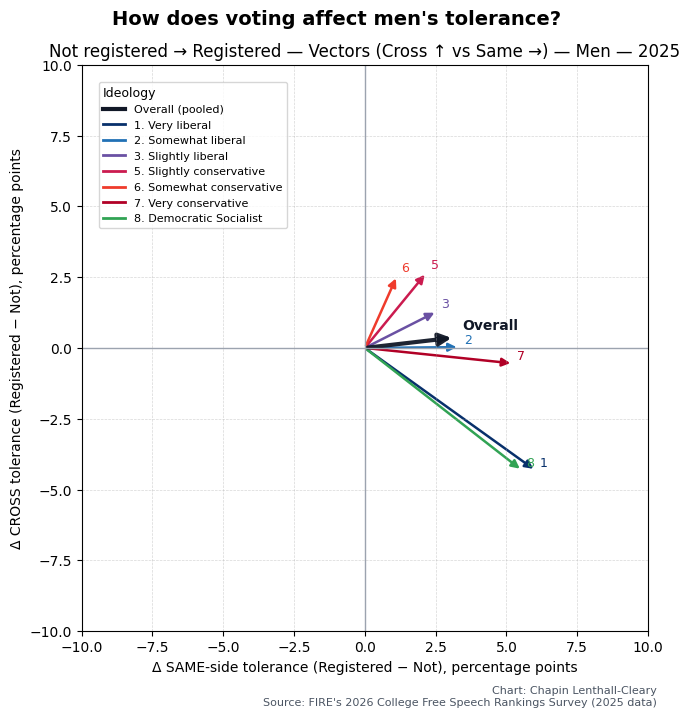


Sample size by registration — Women
Registration status     N
     Not registered  3851
         Registered 27592

Δ (Same, Cross) — Women — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target,n_eff
0,1,Very liberal,4.97,-3.19,5.90,671.0,7630.0,671.0
1,2,Somewhat liberal,1.41,-0.82,1.63,1340.0,9927.0,1340.0
2,3,Slightly liberal,-1.12,-1.80,2.12,706.0,3523.0,706.0
3,5,Slightly conservative,-2.45,-4.10,4.78,333.0,1548.0,333.0
4,6,Somewhat conservative,0.92,-0.61,1.11,437.0,2687.0,437.0
5,7,Very conservative,-2.40,-2.40,3.39,169.0,1619.0,169.0
6,8,Democratic Socialist,10.13,-2.79,10.50,195.0,658.0,195.0


Saved: vectors_cross_same_NotToRegistered_Women_2025.png


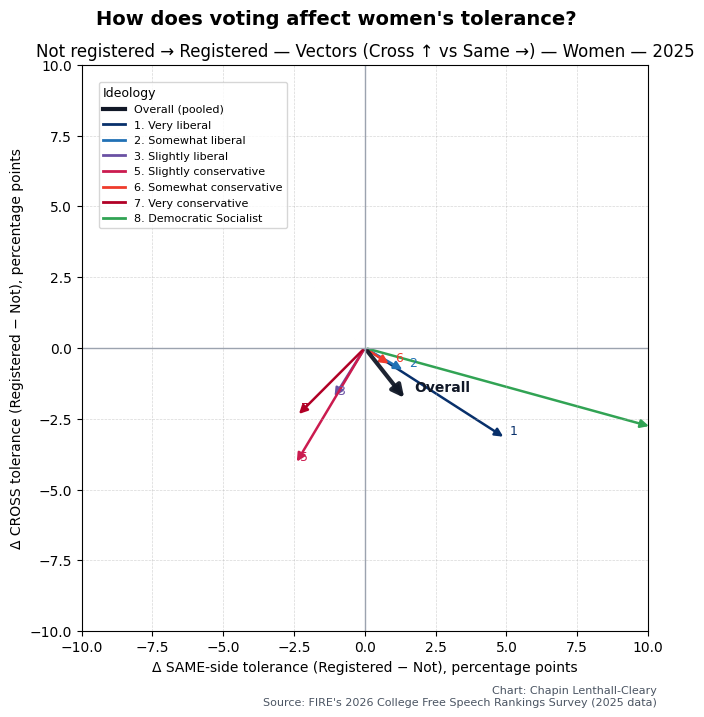

In [7]:
#!/usr/bin/env python3
"""
Vector plots: registration deltas with Cross (Up) vs Same-side (Right) tolerance.

Changes vs original:
- Axes are "Same-side tolerance" (X) and "Cross-tolerance" (Y).
- For liberals & democratic socialists (1,2,3,8):   same=Left, cross=Right.
- For conservatives (5,6,7):                        same=Right, cross=Left.
- Excludes all other ideologies (4,9,10,11).
- Runs for Men and Women (no cohort breakdowns).

Each vector (per included ideology) shows:
  ΔX = Same-side tolerance (Registered − Not), percentage points
  ΔY = Cross-tolerance    (Registered − Not), percentage points
Plus a bold pooled “Overall” arrow (weighted by effective N per ideology).

Inputs
------
- cfsrALL_24_25.csv

Outputs
-------
- vectors_cross_same_NotToRegistered_Men_YYYY.png
- vectors_cross_same_NotToRegistered_Women_YYYY.png
"""

from pathlib import Path
from typing import Dict, Optional, Set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

# ---------- Settings ----------
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

# ---------- Labels & triads ----------
IDEO_LABELS = {
    1: "Very liberal",
    2: "Somewhat liberal",
    3: "Slightly liberal",
    4: "Moderate, middle-of-the-road",
    5: "Slightly conservative",
    6: "Somewhat conservative",
    7: "Very conservative",
    8: "Democratic Socialist",
    9: "Libertarian",
    10: "Haven't thought much about this",
    11: "Something else",
}

REGVOTER_LABELS = {
    0: "Not registered",
    1: "Registered",
}

RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

# Keep only libs/DS + conservatives
LIBERAL_IDS: Set[int] = {1, 2, 3, 8}
CONSERVATIVE_IDS: Set[int] = {5, 6, 7}
INCLUDED_IDS: Set[int] = LIBERAL_IDS | CONSERVATIVE_IDS

# ---------- Colors (ideology-coded) ----------
def ideology_colors() -> Dict[int, str]:
    return {
        1: "#08306b",  # deep navy
        2: "#2171b5",  # blue
        3: "#6a51a3",  # strong purple
        5: "#cb1b4f",  # magenta-red
        6: "#ef3b2c",  # bright red
        7: "#b10026",  # deep red
        8: "#31a354",  # green
    }
IDEO_COLORS = ideology_colors()

# ---------- Helpers ----------
def scale_triad_to_pct(sum_vals: pd.Series, k: int = 3) -> pd.Series:
    """Maps triad sum (k..4k) to 0..100%."""
    return (sum_vals - k) / (3 * k) * 100.0


def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    """Build ideology 1..11 with preference order: fire_ideo → cp_ideo → ideo."""
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")
    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)
    ideo = np.where(valid_fire, fire, np.where(valid_cp, cp, np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")


def load_and_filter(csv_path: Path, year: int) -> pd.DataFrame:
    """
    Load CSV, coerce numerics, build ideology, filter to included ideologies only.
    """
    if not csv_path.exists():
        raise FileNotFoundError(f"Data file not found at: {csv_path.resolve()}")

    df = pd.read_csv(csv_path, low_memory=False)

    # Coerce relevant columns to numeric
    for col in ["datayear", "gender_bin", "regvoter", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Build ideology
    df["ideo"] = build_ideo_like_code(df)

    # Base filters: year, gender, regvoter (0/1), ideology in INCLUDED
    df = df[
        (df["datayear"] == year)
        & (df["gender_bin"].isin([1, 2]))
        & (df["regvoter"].isin([0, 1]))
        & (df["ideo"].isin(list(INCLUDED_IDS)))
    ].copy()
    if df.empty:
        raise ValueError(
            f"No rows after filtering for year={year}, gender in [1,2], regvoter in [0,1], and included ideologies."
        )

    # Require ALL six spk_* in [1,4]
    in_range_spk = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range_spk.all(axis=1)].copy()
    if df.empty:
        raise ValueError("No rows remain after requiring spk_* in [1,4].")

    # Triad sums & scale to percent (0..100)
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    return df


def compute_group_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group means (ideology × gender × regvoter) for left/right tolerance, with Ns.
    Returns columns: ideo, gender_bin, regvoter, left_avg, right_avg, n
    """
    stats = (
        df.groupby(["ideo", "gender_bin", "regvoter"], dropna=True)
          .agg(left_avg=("left_pct", "mean"),
               right_avg=("right_pct", "mean"),
               n=("left_pct", "size"))
          .reset_index()
    )
    return stats


def _same_cross_for_ideo(ideo: int) -> tuple[str, str]:
    """
    Returns column names to use for SAME (x) and CROSS (y) given ideology.
    For libs/DS:     SAME=left_avg,  CROSS=right_avg
    For conservatives SAME=right_avg, CROSS=left_avg
    """
    if ideo in LIBERAL_IDS:
        return "left_avg", "right_avg"
    elif ideo in CONSERVATIVE_IDS:
        return "right_avg", "left_avg"
    else:
        # Should not happen because we filtered; fallback sane default
        return "left_avg", "right_avg"


def prepare_deltas_cross_same_for_gender(
    stats: pd.DataFrame,
    gender_code: int,
    base_reg: int = 0,   # Not registered
    target_reg: int = 1  # Registered
) -> pd.DataFrame:
    """
    For a given gender, compute ideology-wise deltas mapped to SAME (x) and CROSS (y).
      Δx = SAME(target) − SAME(base)
      Δy = CROSS(target) − CROSS(base)
    Keeps only included ideologies where both groups exist.
    Also include n_base, n_target, and n_eff (min of the two) for transparency.
    """
    s = stats[stats["gender_bin"] == gender_code].copy()
    if s.empty:
        return pd.DataFrame(columns=[
            "ideo", "Ideology label", "delta_x", "delta_y", "magnitude",
            "n_base", "n_target", "n_eff"
        ])

    # Pivots for means and counts
    left_p  = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    right_p = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_p     = s.pivot(index="ideo", columns="regvoter", values="n")

    rows = []
    for ideo in sorted(INCLUDED_IDS):
        if ideo not in left_p.index:
            continue
        same_col, cross_col = _same_cross_for_ideo(ideo)

        # Extract base/target SAME and CROSS means
        def get_val(colname):
            if colname == "left_avg":
                return left_p.get(target_reg), left_p.get(base_reg)
            else:
                return right_p.get(target_reg), right_p.get(base_reg)

        # We need numbers for SAME and CROSS
        same_t, same_b   = get_val(same_col)
        cross_t, cross_b = get_val(cross_col)

        # if any missing for this ideology, skip
        try:
            same_t_val  = float(same_t.loc[ideo])
            same_b_val  = float(same_b.loc[ideo])
            cross_t_val = float(cross_t.loc[ideo])
            cross_b_val = float(cross_b.loc[ideo])
        except Exception:
            continue

        n_base   = float(n_p.get(base_reg).loc[ideo]) if base_reg in n_p.columns else np.nan
        n_target = float(n_p.get(target_reg).loc[ideo]) if target_reg in n_p.columns else np.nan
        n_eff    = float(np.nanmin([n_base, n_target])) if (not np.isnan(n_base) or not np.isnan(n_target)) else np.nan

        dx = same_t_val - same_b_val
        dy = cross_t_val - cross_b_val
        rows.append({
            "ideo": ideo,
            "Ideology label": IDEO_LABELS.get(ideo, str(ideo)),
            "delta_x": dx,
            "delta_y": dy,
            "magnitude": np.sqrt(dx**2 + dy**2),
            "n_base": n_base,
            "n_target": n_target,
            "n_eff": n_eff,
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return out
    return out.sort_values("ideo")


def compute_overall_delta_cross_same(
    df_deltas: pd.DataFrame
) -> dict | None:
    """
    Overall arrow computed from ideology-level deltas, weighted by effective N
    (min of base/target per ideology). Returns dict with delta_x, delta_y,
    and totals for n_base and n_target across included ideologies.
    """
    if df_deltas is None or df_deltas.empty:
        return None
    # weights: effective N; if any missing, drop those rows
    w = df_deltas["n_eff"].copy()
    mask = ~pd.isna(w) & (w > 0)
    if not mask.any():
        return None

    w = w[mask]
    dx = np.average(df_deltas.loc[mask, "delta_x"], weights=w)
    dy = np.average(df_deltas.loc[mask, "delta_y"], weights=w)
    return {
        "delta_x": float(dx),
        "delta_y": float(dy),
        "n_base":  int(np.nansum(df_deltas.loc[mask, "n_base"])),
        "n_target": int(np.nansum(df_deltas.loc[mask, "n_target"])),
    }


def plot_vectors_for_gender(
    df_deltas: pd.DataFrame,
    pair_label: str,
    gender_label: str,
    year: int,
    save_path: Path | None = None,
    overall_delta: dict | None = None,
    suptitle: Optional[str] = None,
):
    """
    Square figure; ideology-colored vectors from origin.
    X = Δ SAME-SIDE tolerance ; Y = Δ CROSS tolerance

    Adds a gender-specific headline above the plot and bottom-right credits
    formatted like the scatter script.
    """
    fig, ax = plt.subplots(figsize=(8, 8))  # KEEP SIZE

    # Crosshairs at origin
    ax.axhline(0, linewidth=1.0, color="#9ca3af")
    ax.axvline(0, linewidth=1.0, color="#9ca3af")

    # One vector per ideology (color-coded)
    for _, r in df_deltas.iterrows():
        i = int(r["ideo"])
        color = IDEO_COLORS.get(i, "#9ca3af")
        dx = float(r["delta_x"])
        dy = float(r["delta_y"])
        n_eff = r.get("n_eff", np.nan)
        ls = "--" if (not pd.isna(n_eff) and n_eff < 40) else "-"
        ax.add_patch(FancyArrowPatch((0.0, 0.0), (dx, dy),
                                     arrowstyle="-|>", mutation_scale=12, linewidth=1.8,
                                     color=color, linestyle=ls))
        ax.annotate(str(i), xy=(dx, dy), xytext=(3, 3),
                    textcoords="offset points", fontsize=9, color=color)

    # Pooled "Overall" arrow (thicker, dark)
    overall_handle = None
    if overall_delta is not None:
        odx = float(overall_delta["delta_x"])
        ody = float(overall_delta["delta_y"])
        n_eff_overall = min(overall_delta["n_base"], overall_delta["n_target"])
        ls_overall = "--" if n_eff_overall < 40 else "-"
        ax.add_patch(FancyArrowPatch(
            (0.0, 0.0), (odx, ody),
            arrowstyle="-|>", mutation_scale=18, linewidth=3.0,
            color="#111827", linestyle=ls_overall, alpha=0.95
        ))
        ax.annotate("Overall", xy=(odx, ody), xytext=(6, 6),
                    textcoords="offset points", fontsize=10, color="#111827",
                    fontweight="bold")
        overall_handle = Line2D([0],[0], color="#111827", lw=3, label="Overall (pooled)")

    # Fixed symmetric limits for quick comparability
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_aspect("equal")

    ax.set_xlabel("Δ SAME-side tolerance (Registered − Not), percentage points")
    ax.set_ylabel("Δ CROSS tolerance (Registered − Not), percentage points")
    ax.set_title(f"{pair_label} — Vectors (Cross ↑ vs Same →) — {gender_label} — {year}")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Legend (TOP-LEFT) — include Overall if available, only included ideologies
    handles = []
    if overall_handle is not None:
        handles.append(overall_handle)
    for i in sorted(INCLUDED_IDS):
        handles.append(Line2D([0],[0], color=IDEO_COLORS.get(i, "#9ca3af"), lw=2, label=f"{i}. {IDEO_LABELS[i]}"))
    leg = ax.legend(
        handles=handles,
        title="Ideology",
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fontsize=8,
        title_fontsize=9,
        frameon=True,
        borderaxespad=0.5,
    )
    try:
        leg._legend_box.align = "left"
    except Exception:
        pass

    # >>> Headline & Credits (formatted like Code 2) <<<
    fig.suptitle(
        suptitle if suptitle else "How does voting affect tolerance?",
        fontsize=14, fontweight="bold", y=0.9
    )
    fig.text(
        0.9, 0.028,
        "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
        ha="right", va="bottom", fontsize=8, color="#4b5563"
    )

    # Leave room for the titles/credits while keeping axes size effectively unchanged
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.92])

    if save_path is not None:
        fig.savefig(save_path, dpi=150)
        print(f"Saved: {save_path}")
    plt.show()


def print_reg_counts_table(df: pd.DataFrame, gender_code: int):
    label = "Men" if gender_code == 1 else "Women"
    counts = (
        df.loc[df["gender_bin"] == gender_code, "regvoter"]
          .value_counts()
          .reindex([0, 1], fill_value=0)
          .rename(index=REGVOTER_LABELS)
    )
    out = counts.reset_index()
    out.columns = ["Registration status", "N"]
    print(f"\nSample size by registration — {label}")
    print(out.to_string(index=False))


def run():
    """
    Build plots for both genders (no cohort breakdowns).
    """
    print("\n=== Men & Women ===")
    df = load_and_filter(CSV_PATH, YEAR)
    stats = compute_group_means(df)

    pair_label = "Not registered → Registered"

    # --- MEN ---
    gender_label = "Men"
    print_reg_counts_table(df, gender_code=1)

    men_deltas = prepare_deltas_cross_same_for_gender(stats, gender_code=1, base_reg=0, target_reg=1)
    men_overall = compute_overall_delta_cross_same(men_deltas)
    if men_deltas.empty:
        print("No data for Men after filtering.")
    else:
        try:
            from IPython.display import display
            print("\nΔ (Same, Cross) — Men — Not registered → Registered")
            display(men_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}))
        except Exception:
            print("\nΔ (Same, Cross) — Men — Not registered → Registered")
            print(men_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}).to_string(index=False))
        plot_vectors_for_gender(
            men_deltas,
            pair_label=pair_label,
            gender_label=gender_label,
            year=YEAR,
            save_path=Path(f"vectors_cross_same_NotToRegistered_Men_{YEAR}.png"),
            overall_delta=men_overall,
            suptitle="How does voting affect men's tolerance?",
        )

    # --- WOMEN ---
    gender_label = "Women"
    print_reg_counts_table(df, gender_code=2)

    women_deltas = prepare_deltas_cross_same_for_gender(stats, gender_code=2, base_reg=0, target_reg=1)
    women_overall = compute_overall_delta_cross_same(women_deltas)
    if women_deltas.empty:
        print("No data for Women after filtering.")
    else:
        try:
            from IPython.display import display
            print("\nΔ (Same, Cross) — Women — Not registered → Registered")
            display(women_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}))
        except Exception:
            print("\nΔ (Same, Cross) — Women — Not registered → Registered")
            print(women_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}).to_string(index=False))
        plot_vectors_for_gender(
            women_deltas,
            pair_label=pair_label,
            gender_label=gender_label,
            year=YEAR,
            save_path=Path(f"vectors_cross_same_NotToRegistered_Women_{YEAR}.png"),
            overall_delta=women_overall,
            suptitle="How does voting affect women's tolerance?",
        )


def main():
    run()


if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error while processing: {e}")


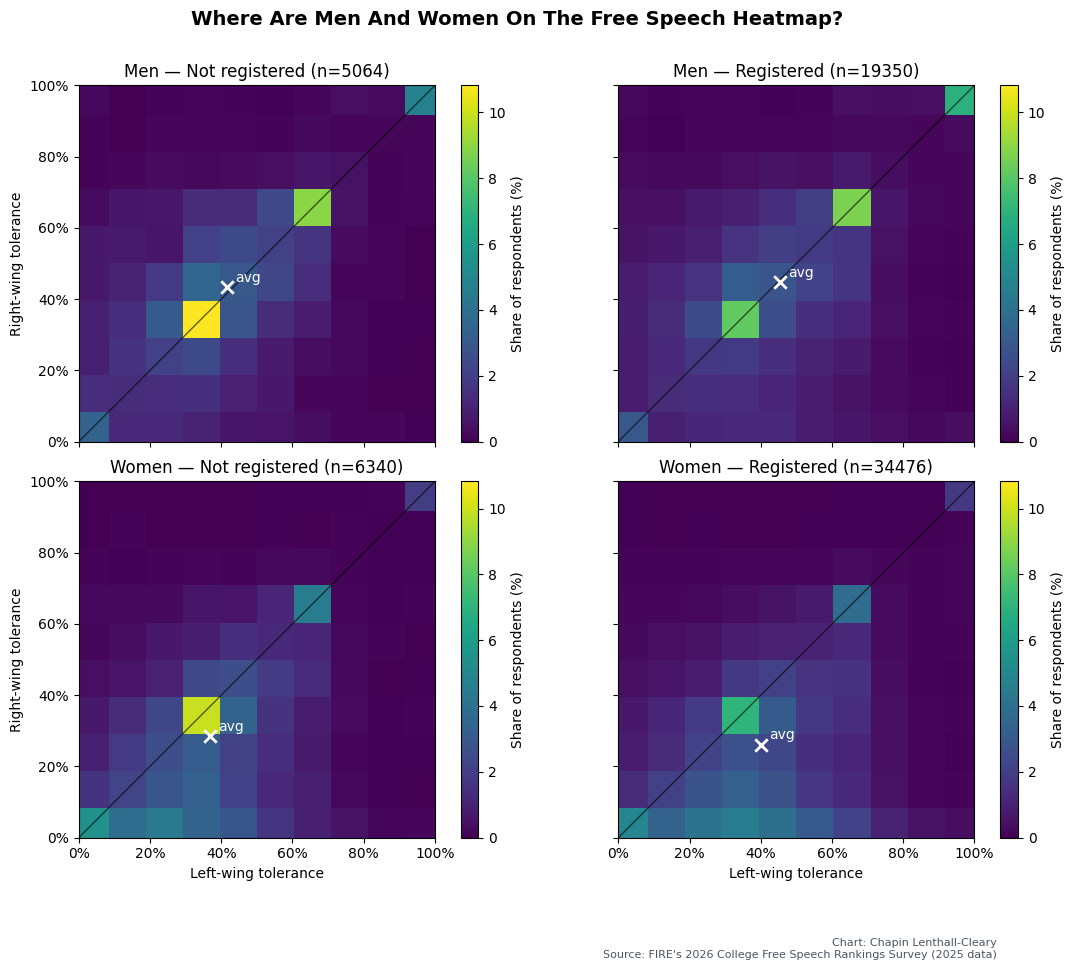

Figure saved to: /Users/chapin.lenthall-cleary/heatmap_left_vs_right_by_gender_reg.png


In [8]:
#!/usr/bin/env python3
"""
Heatmaps of tolerance for Left- vs Right-wing speakers (x = Left, y = Right),
now shown separately for Men/Women × Registration (Not registered / Registered).

Each panel bins respondents into ~10pp cells and colors by the share of respondents
in that bin. Values are scaled to 0–100% using the same mapping as your triad plots
(sum k..4k -> 0..100 where k=len(triad)=3).

Outputs one figure with FOUR panels (2×2) and saves it to:
  heatmap_left_vs_right_by_gender_reg.png
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path

# --- Config ---
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025
GENDER_LABELS = {1: "Men", 2: "Women"}
REG_LABELS = {0: "Not registered", 1: "Registered"}

# Keep your original triads/naming
RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]          # "Right-wing Speakers" per your scripts
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]  # "Left-wing Speakers"
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD


def scale_triad_to_pct(sum_vals, k=3):
    """Maps triad sum (k..4k) to 0..100%."""
    return (sum_vals - k) / (3 * k) * 100.0


def make_joint_heatmaps(df, year):
    """
    df: already filtered to year, gender=={1,2}, regvoter=={0,1}, all six spk_* in [1,4]
    Creates a 2×2 figure:
        [ Men / Not registered | Men / Registered ]
        [ Women / Not registered | Women / Registered ]
    Heatmaps of Left (x) vs Right (y) tolerance.
    """
    # Compute triad sums & scale to percent (0..100)
    df = df.copy()
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)

    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    # Binning edges: 0..100 with a small buffer so edge values show
    edges = np.linspace(-2, 102, 11)  # ~10% bins with a touch of breathing room

    # First pass: compute normalized grids to get a common vmax (percent)
    grids = {}
    cmax = 0.0
    for g in [1, 2]:
        for r in [0, 1]:
            sub = df[(df["gender_bin"] == g) & (df["regvoter"] == r)]
            if sub.empty:
                H = np.zeros((len(edges)-1, len(edges)-1))
                pct = H
                xedges = yedges = edges
                n = 0
            else:
                # NOTE: x = Left, y = Right
                H, xedges, yedges = np.histogram2d(
                    sub["left_pct"], sub["right_pct"],
                    bins=[edges, edges]
                )
                pct = (H / len(sub)) * 100.0  # percent of respondents in each bin
                n = len(sub)
            grids[(g, r)] = (pct, xedges, yedges, n)
            cmax = max(cmax, float(pct.max()) if pct.size else 0.0)

    # Figure size: keep EACH panel the same as before (1×2 used (12,5) → per-axes ~6×5).
    # For 2×2, use (12,10) to keep per-axes size roughly unchanged.
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

    # Second pass: plot with a common vmax so colors are comparable
    for row_i, g in enumerate([1, 2]):
        for col_j, r in enumerate([0, 1]):
            ax = axes[row_i, col_j]
            pct, xedges, yedges, n = grids[(g, r)]

            mesh = ax.pcolormesh(
                xedges, yedges, pct.T,
                shading="auto",
                vmin=0, vmax=max(1e-9, cmax)
            )
            cb = fig.colorbar(mesh, ax=ax)
            cb.set_label("Share of respondents (%)")

            # Axes formatting
            ax.set_title(f"{GENDER_LABELS[g]} — {REG_LABELS[r]} (n={n})")
            if row_i == 1:
                ax.set_xlabel("Left-wing tolerance")
            if col_j == 0:
                ax.set_ylabel("Right-wing tolerance")

            ax.set_xlim(0, 100)
            ax.set_ylim(0, 100)
            ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
            ax.set_aspect("equal", adjustable="box")

            # Diagonal parity line
            ax.plot([0, 100], [0, 100], color="black", linewidth=1, alpha=0.6)

            # Group means (x=Left, y=Right)
            sub = df[(df["gender_bin"] == g) & (df["regvoter"] == r)]
            if not sub.empty:
                mx = sub["left_pct"].mean()
                my = sub["right_pct"].mean()
                ax.scatter([mx], [my], marker="x", s=80, color="white", linewidths=2, zorder=3)
                ax.annotate("avg", (mx, my), textcoords="offset points", xytext=(6, 4), color="white")

    # Headline (Code 2 style)
    fig.suptitle(
        "Where Are Men And Women On The Free Speech Heatmap?",
        fontsize=14, fontweight="bold", y=0.93
    )

    # Credits in the lower-right (Code 2 style)
    fig.text(
        0.9, -0.02,
        "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
        ha="right", va="bottom", fontsize=8, color="#4b5563"
    )

    # Leave space for the headline/credits without changing per-axes size
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.92])

    out_path = Path("heatmap_left_vs_right_by_gender_reg.png")
    fig.savefig(out_path, dpi=150)
    plt.show()
    print(f"Figure saved to: {out_path.resolve()}")


def main():
    # Load
    df = pd.read_csv(CSV_PATH, low_memory=False)

    # Coerce relevant columns to numeric
    numeric_cols = ["datayear", "gender_bin", "regvoter", *SPK_ALL]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to target year, men/women only, and registration in {0,1}
    df = df[(df["datayear"] == YEAR) & (df["gender_bin"].isin([1, 2])) & (df["regvoter"].isin([0, 1]))]
    if df.empty:
        raise SystemExit(f"No rows found for datayear == {YEAR}, gender_bin in [1,2], and regvoter in [0,1].")

    # Require ALL six spk_* in [1,4], matching your earlier scripts
    in_range = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range.all(axis=1)].copy()
    if df.empty:
        raise SystemExit("No rows remain after requiring all six spk_* to be in [1,4].")

    # Make the 2×2 heatmaps by gender × registration
    make_joint_heatmaps(df, YEAR)


if __name__ == "__main__":
    main()


overall, all men: N_base=5064, N_target=19350
overall, excl. perfect men: N_base=4826, N_target=18016
Saved: vectors_overall_only_Men_comparison_2025.png


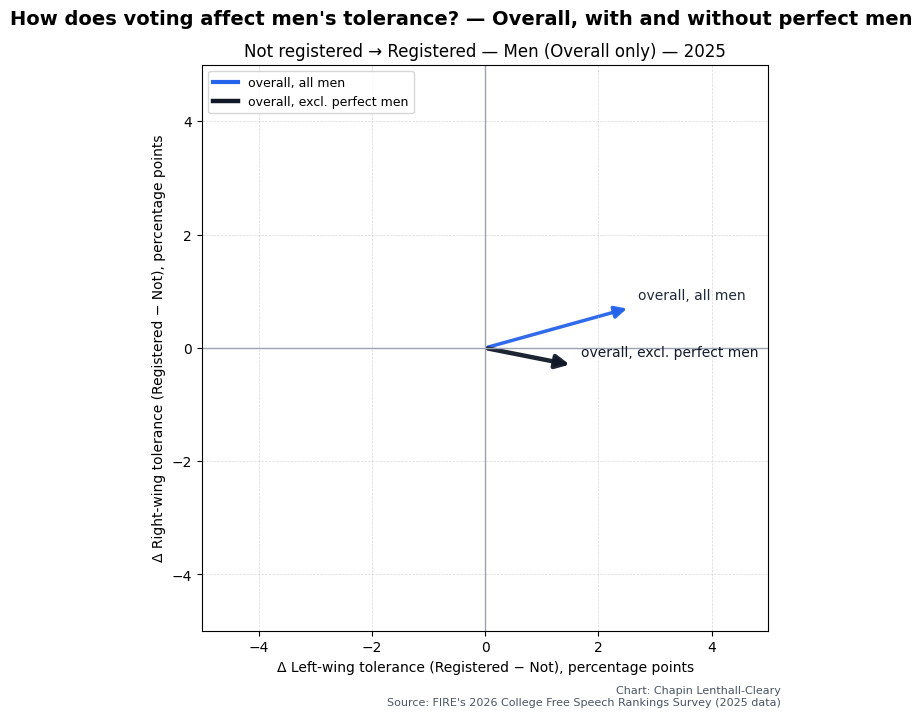

In [12]:
#!/usr/bin/env python3
"""
Two-arrow comparison plot for Men:
  • overall, all men
  • overall, excl. perfect men (100% tolerance on BOTH Left & Right)

Estimator (for both arrows):
  Matched-delta overall arrow:
    • Compute per-ideology deltas only for ideologies that exist in BOTH reg statuses.
    • Pool with weights w_i = min(n_i_base, n_i_target).

Inputs
------
- cfsrALL_24_25.csv

Outputs
-------
- vectors_overall_only_Men_comparison_YYYY.png

Usage
-----
- Ensure cfsrALL_24_25.csv is next to this file
- Adjust YEAR if needed
- Run: python vector_overall_men_comparison.py
"""

from pathlib import Path
from typing import Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

# ---------- Settings ----------
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

# ---------- Triads ----------
RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

# ---------- Helpers ----------
def scale_triad_to_pct(sum_vals: pd.Series, k: int = 3) -> pd.Series:
    """Maps triad sum (k..4k) to 0..100%."""
    return (sum_vals - k) / (3 * k) * 100.0

def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    """Build ideology 1..11 with preference order: fire_ideo → cp_ideo → ideo."""
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")
    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)
    ideo = np.where(valid_fire, fire, np.where(valid_cp, cp, np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")

def base_load(csv_path: Path, year: int) -> pd.DataFrame:
    """
    Load CSV, coerce numerics, build ideology, and apply base filters.
    Does NOT exclude 'perfect men' — we create a second dataset later that does.
    """
    if not csv_path.exists():
        raise FileNotFoundError(f"Data file not found at: {csv_path.resolve()}")

    df = pd.read_csv(csv_path, low_memory=False)

    # Coerce relevant columns to numeric
    for col in ["datayear", "gender_bin", "regvoter", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Build ideology
    df["ideo"] = build_ideo_like_code(df)

    # Keep this year, valid genders/registration/ideo
    df = df[
        (df["datayear"] == year)
        & (df["gender_bin"].isin([1, 2]))
        & (df["regvoter"].isin([0, 1]))
        & (df["ideo"].isin(range(1, 12)))
    ].copy()
    if df.empty:
        raise ValueError(
            f"No rows after filtering for year={year}, gender in [1,2], regvoter in [0,1], and ideo in 1..11."
        )

    # Require ALL six spk_* in [1,4]
    in_range_spk = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range_spk.all(axis=1)].copy()
    if df.empty:
        raise ValueError("No rows remain after requiring spk_* in [1,4].")

    # Triad sums & scale to percent (0..100)
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    return df

def exclude_perfect_men(df: pd.DataFrame) -> pd.DataFrame:
    """
    Exclude MEN (gender_bin == 1) who have 100% tolerance on BOTH left and right.
    Uses triad sums to avoid float comparison (4*k equals 100%).
    """
    perfect_men_mask = (
        (df["gender_bin"] == 1)
        & (df["left_sum"]  == 4 * len(LEFT_TRIAD))
        & (df["right_sum"] == 4 * len(RIGHT_TRIAD))
    )
    return df.loc[~perfect_men_mask].copy()

def compute_group_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group means (ideology × gender × regvoter) for left/right tolerance, with Ns.
    Returns columns: ideo, gender_bin, regvoter, left_avg, right_avg, n
    """
    stats = (
        df.groupby(["ideo", "gender_bin", "regvoter"], dropna=True)
          .agg(left_avg=("left_pct", "mean"),
               right_avg=("right_pct", "mean"),
               n=("left_pct", "size"))
          .reset_index()
    )
    return stats

def compute_overall_delta_for_gender(
    stats: pd.DataFrame,
    gender_code: int,
    base_reg: int = 0,
    target_reg: int = 1
) -> dict | None:
    """
    Matched-delta overall arrow for a gender:
      • Compute per-ideology deltas only for ideologies that have BOTH reg statuses.
      • Pool deltas with weights w_i = min(n_i_base, n_i_target).
    Returns dict with delta_x, delta_y, n_base, n_target or None if unavailable.
    """
    s = stats[stats["gender_bin"] == gender_code]
    if s.empty:
        return None

    x_pivot = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    y_pivot = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_pivot = s.pivot(index="ideo", columns="regvoter", values="n")

    # Need both statuses present
    for p in (x_pivot, y_pivot, n_pivot):
        if base_reg not in p.columns or target_reg not in p.columns:
            return None

    x_pair = x_pivot[[base_reg, target_reg]].dropna()
    y_pair = y_pivot[[base_reg, target_reg]].dropna()
    n_pair = n_pivot[[base_reg, target_reg]].dropna()

    common = x_pair.index.intersection(y_pair.index).intersection(n_pair.index)
    if len(common) == 0:
        return None

    dx = (x_pair.loc[common, target_reg] - x_pair.loc[common, base_reg]).astype(float)
    dy = (y_pair.loc[common, target_reg] - y_pair.loc[common, base_reg]).astype(float)
    w  = np.minimum(n_pair.loc[common, base_reg], n_pair.loc[common, target_reg]).astype(float)

    mask = (w > 0) & dx.notna() & dy.notna()
    if not mask.any():
        return None

    sel = w.index[mask]
    delta_x = float(np.average(dx.loc[sel], weights=w.loc[sel]))
    delta_y = float(np.average(dy.loc[sel], weights=w.loc[sel]))

    return {
        "delta_x":  delta_x,
        "delta_y":  delta_y,
        "n_base":   int(n_pair.loc[sel, base_reg].sum()),
        "n_target": int(n_pair.loc[sel, target_reg].sum()),
    }

# ---------- Plot: two arrows only (old vs new) ----------
def plot_overall_comparison_men(old_overall: dict | None,
                                new_overall: dict | None,
                                year: int,
                                save_path: Path | None = None):
    """
    Draw a square plot with ONLY two arrows from the origin:
      • overall, all men
      • overall, excl. perfect men
    """
    if old_overall is None and new_overall is None:
        print("No overall deltas available to plot.")
        return

    fig, ax = plt.subplots(figsize=(8, 8))  # keep square

    # Crosshairs at origin
    ax.axhline(0, linewidth=1.0, color="#9ca3af")
    ax.axvline(0, linewidth=1.0, color="#9ca3af")

    handles = []

    # Old arrow (ALL men)
    if old_overall is not None:
        odx = float(old_overall["delta_x"])
        ody = float(old_overall["delta_y"])
        n_eff_old = min(old_overall["n_base"], old_overall["n_target"])
        ls_old = "--" if n_eff_old < 40 else "-"
        ax.add_patch(FancyArrowPatch(
            (0.0, 0.0), (odx, ody),
            arrowstyle="-|>", mutation_scale=18, linewidth=2.5,
            color="#2563eb", linestyle=ls_old, alpha=0.95
        ))
        ax.annotate("overall, all men", xy=(odx, ody), xytext=(6, 6),
                    textcoords="offset points", fontsize=10, color="#1f2937")
        handles.append(Line2D([0],[0], color="#2563eb", lw=3,
                              label="overall, all men"))

    # New arrow (excluding perfect men)
    if new_overall is not None:
        ndx = float(new_overall["delta_x"])
        ndy = float(new_overall["delta_y"])
        n_eff_new = min(new_overall["n_base"], new_overall["n_target"])
        ls_new = "--" if n_eff_new < 40 else "-"
        ax.add_patch(FancyArrowPatch(
            (0.0, 0.0), (ndx, ndy),
            arrowstyle="-|>", mutation_scale=20, linewidth=3.2,
            color="#111827", linestyle=ls_new, alpha=0.95
        ))
        ax.annotate("overall, excl. perfect men", xy=(ndx, ndy), xytext=(6, 6),
                    textcoords="offset points", fontsize=10, color="#111827")
        handles.append(Line2D([0],[0], color="#111827", lw=3.2,
                              label="overall, excl. perfect men"))

    # Zoomed limits per request
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect("equal")

    ax.set_xlabel("Δ Left-wing tolerance (Registered − Not), percentage points")
    ax.set_ylabel("Δ Right-wing tolerance (Registered − Not), percentage points")
    ax.set_title(f"Not registered → Registered — Men (Overall only) — {year}")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    if handles:
        leg = ax.legend(handles=handles, loc="upper left", fontsize=9, frameon=True)
        try:
            leg._legend_box.align = "left"
        except Exception:
            pass

    # Credits
    fig.suptitle("How does voting affect men's tolerance? — Overall, with and without perfect men",
                 fontsize=14, fontweight="bold", y=0.9)
    fig.text(
        0.9, 0.028,
        "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
        ha="right", va="bottom", fontsize=8, color="#4b5563"
    )
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.92])

    if save_path is not None:
        fig.savefig(save_path, dpi=150)
        print(f"Saved: {save_path}")

    plt.show()

def main():
    # Load once (includes both genders; we’ll filter to men downstream)
    df_all = base_load(CSV_PATH, YEAR)

    # -------- overall, all men --------
    men_all = df_all[df_all["gender_bin"] == 1].copy()
    stats_all = compute_group_means(men_all)  # men only
    old_overall = compute_overall_delta_for_gender(stats_all, gender_code=1, base_reg=0, target_reg=1)

    # -------- overall, excl. perfect men --------
    men_excl = exclude_perfect_men(men_all)
    stats_excl = compute_group_means(men_excl)
    new_overall = compute_overall_delta_for_gender(stats_excl, gender_code=1, base_reg=0, target_reg=1)

    # Optional: print Ns used
    def fmt(o):
        return "n/a" if o is None else f"N_base={o['n_base']}, N_target={o['n_target']}"
    print("overall, all men:", fmt(old_overall))
    print("overall, excl. perfect men:", fmt(new_overall))

    # -------- PLOT (two arrows only) --------
    outpath = Path(f"vectors_overall_only_Men_comparison_{YEAR}.png")
    plot_overall_comparison_men(old_overall, new_overall, year=YEAR, save_path=outpath)

if __name__ == "__main__":
    main()


In [ ]:
#plots below are for the short datapost

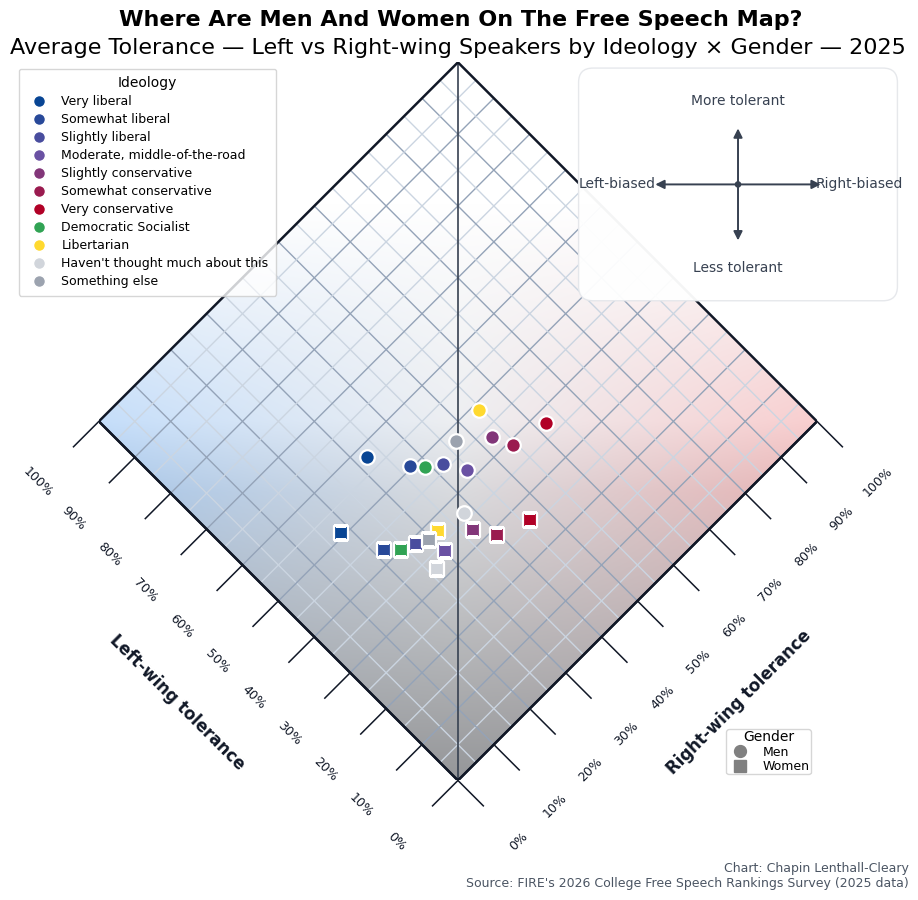

Figure saved to: /Users/chapin.lenthall-cleary/scatter_left_vs_right_avg_by_ideology_gender.png


In [44]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch, Circle, Polygon
from pathlib import Path

# --- Config ---
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

# --- Compass sizing/position (manual placement) ---
BASE_COMPASS_W     = 0.30
BASE_COMPASS_H     = 0.30
H_EXPAND_PP        = 0.12   # a touch larger on the bigger figure

COMPASS_W   = BASE_COMPASS_W + H_EXPAND_PP
COMPASS_H   = BASE_COMPASS_H
COMPASS_PAD = 0.02          # distance from top/right edges (0..1 of axes)
COMPASS_SHIFT = -0.12        # 0 = as far RIGHT as possible; increase to move LEFT

# --- Ideology legend placement (manual) ---
# Axes coordinates: (0,0)=bottom-left of plot area; (1,1)=top-right.
IDEO_LEG_X_AX = -0.12        # 0 = flush left edge; increase to move right
IDEO_LEG_Y_AX = 1.00        # 1 = top edge (same height as default "upper left")

IDEO_LABELS = {
    1: "Very liberal", 2: "Somewhat liberal", 3: "Slightly liberal",
    4: "Moderate, middle-of-the-road", 5: "Slightly conservative",
    6: "Somewhat conservative", 7: "Very conservative",
    8: "Democratic Socialist", 9: "Libertarian",
    10: "Haven't thought much about this", 11: "Something else",
}

# Triads
RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

def scale_triad_to_pct(sum_vals, k=3):
    return (sum_vals - k) / (3 * k) * 100.0

def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")
    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)
    ideo = np.where(valid_fire, fire, np.where(valid_cp, cp, np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")

# ---------- Diamond coordinate mapping ----------
P0 = np.array([50.0, 0.0])       # bottom vertex
VL = np.array([-50.0, 50.0])     # toward left vertex
VR = np.array([ 50.0, 50.0])     # toward right vertex

def to_diamond(L, R):
    """Map (L,R) in [0..100]x[0..100] to diamond data coords; returns (x, y)."""
    sL, sR = np.asarray(L)/100.0, np.asarray(R)/100.0
    xy = P0 + sL*VL + sR*VR
    return float(xy[0]), float(xy[1])

# ---------- 2-D gradient background (clipped to diamond) ----------
def _add_2d_gradient_bg(ax, diamond_outline, *, nx=800, ny=800):
    x = np.linspace(0.0, 1.0, nx)
    y = np.linspace(0.0, 1.0, ny)
    X, Y = np.meshgrid(x, y)

    c_left  = np.array(to_rgb("#93c5fd"))  # blue-300
    c_mid   = np.array(to_rgb("#e5e7eb"))  # gray-200 (neutral mid)
    c_right = np.array(to_rgb("#fca5a5"))  # red-300

    H = np.zeros((ny, nx, 3), dtype=float)
    uL = np.clip(2*X, 0, 1)
    uR = np.clip(2*(X - 0.5), 0, 1)
    for ch in range(3):
        H[..., ch] = np.where(
            X <= 0.5,
            (1 - uL) * c_left[ch] + uL * c_mid[ch],
            (1 - uR) * c_mid[ch]  + uR * c_right[ch]
        )

    white = np.array(to_rgb("#ffffff"))
    gray  = np.array(to_rgb("#e5e7eb"))
    t = np.clip(Y / 0.80, 0, 1)
    V = (1 - t)[..., None] * gray + t[..., None] * white

    bell = 1.0 - np.abs(2*t - 1.0)
    alpha = 0.65 * bell
    IMG = (1 - alpha)[..., None] * V + alpha[..., None] * H

    bottom_cutoff = 1.0 / 2.0
    shade_strength = np.clip((bottom_cutoff - Y) / bottom_cutoff, 0.0, 1.0)
    max_darken = 0.35
    darken_factor = 1.0 - max_darken * shade_strength[..., None]
    IMG *= darken_factor
    IMG = np.clip(IMG, 0.0, 1.0)

    IMG[Y >= 0.85] = white

    im = ax.imshow(
        IMG, origin="lower",
        extent=[0, 100, 0, 100],
        interpolation="bilinear",
        zorder=-10
    )
    im.set_clip_path(diamond_outline)

# ---------- Compass (upright labels; arrows match diamond orientation) ----------
def add_compass(ax, *, width, height, pad=0.02, shift_left,
                directions_deg, labels):
    # Right-aligned; shift_left pushes it left by that fraction of axes width
    cx = 1 - pad - width / 2 - shift_left
    cy = 1 - pad - height / 2

    # Draw the box in axes coords but DO NOT clip to the axes,
    # so the right edge shows even if it extends past x=1.
    compass_box = FancyBboxPatch(
        (cx - width/2, cy - height/2), width, height,
        transform=ax.transAxes, boxstyle="round,pad=0.012,rounding_size=0.02",
        linewidth=1.0, facecolor="white", edgecolor="#e5e7eb", alpha=0.96, zorder=8
    )
    compass_box.set_clip_on(False)
    ax.add_patch(compass_box)

    hx, hy = width / 2.0, height / 2.0
    m = min(width, height) * 0.06

    def r_max(theta):
        ct, st = abs(np.cos(theta)), abs(np.sin(theta))
        ct = max(ct, 1e-9); st = max(st, 1e-9)
        return min((hx - m) / ct, (hy - m) / st)

    color = "#374151"; lw = 1.4; ms = 13; fz = 10.0

    for angle_deg, label in zip(directions_deg, labels):
        th = np.deg2rad(angle_deg)
        rmax = r_max(th)
        r_arrow = rmax * 0.62
        r_label = rmax * 0.88

        x_tip = cx + r_arrow * np.cos(th)
        y_tip = cy + r_arrow * np.sin(th)
        arr = FancyArrowPatch(
            (cx, cy), (x_tip, y_tip),
            transform=ax.transAxes, arrowstyle="-|>", mutation_scale=ms,
            linewidth=lw, color=color, zorder=9
        )
        arr.set_clip_on(False)
        ax.add_patch(arr)

        txt = ax.text(cx + r_label*np.cos(th), cy + r_label*np.sin(th),
                      label, transform=ax.transAxes, ha="center", va="center",
                      fontsize=fz, color=color, zorder=10)
        txt.set_clip_on(False)

    center = Circle((cx, cy), radius=min(width, height) * 0.012,
                    transform=ax.transAxes, color=color, zorder=10)
    center.set_clip_on(False)
    ax.add_patch(center)

# ---------- Oblique edge axes along the lower diamond sides ----------
def _draw_edge_axis(ax, p0, p1, *, label, tick_vals=range(0, 101, 10),
                    tick_len=4.0, label_pad=18.0, tick_label_pad=6.0,
                    label_fontsize=12, tick_fontsize=9, color="#111827",
                    increasing_from="start"):
    p0 = np.asarray(p0, float); p1 = np.asarray(p1, float)
    v = p1 - p0
    L = float(np.hypot(v[0], v[1]))
    if L == 0: return
    u = v / L

    # outward normal pointing "below"
    n_cw  = np.array([ u[1], -u[0]])
    n_ccw = np.array([-u[1],  u[0]])
    n = n_cw if n_cw[1] < n_ccw[1] else n_ccw

    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=color, linewidth=1.6, zorder=4)
    edge_angle_deg = np.degrees(np.arctan2(v[1], v[0]))

    for t in tick_vals:
        s = t / 100.0
        pt = (p1 - u*(s*L)) if (increasing_from == "end") else (p0 + u*(s*L))
        p_tick_end = pt + n * tick_len
        ax.plot([pt[0], p_tick_end[0]], [pt[1], p_tick_end[1]],
                color=color, linewidth=1.1, zorder=4, clip_on=False)

        p_text = pt + n * (tick_len + tick_label_pad)
        ax.text(p_text[0], p_text[1], f"{t}%", ha="center", va="center",
                fontsize=tick_fontsize, color=color,
                rotation=edge_angle_deg, rotation_mode="anchor",
                zorder=5, clip_on=False)

    mid = (p0 + p1) / 2.0
    p_label = mid + n * label_pad
    ax.text(p_label[0], p_label[1], label, ha="center", va="center",
            fontsize=label_fontsize, color=color, fontweight="bold",
            rotation=edge_angle_deg, rotation_mode="anchor",
            zorder=5, clip_on=False)

def make_ideo_gender_scatter(df: pd.DataFrame, year: int):
    df = df.copy()
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    stats = (df.groupby(["ideo", "gender_bin"], dropna=True)
               .agg(left_avg=("left_pct", "mean"),
                    right_avg=("right_pct", "mean"),
                    n=("left_pct", "size"))
               .reset_index())
    if stats.empty:
        raise SystemExit("No groups to plot after filtering—check data/filtering.")

    # --- Bigger figure / typography ---
    fig, ax = plt.subplots(figsize=(11.2, 11.0))  # larger canvas
    title_fs = 16
    sup_fs   = 16
    credit_fs= 9

    # Colors
    cmap_lr = LinearSegmentedColormap.from_list("blue_purple_red",
                                                ["#084594", "#6a51a3", "#b10026"])
    steps7 = np.linspace(0, 1, 7)
    ideology_colors = {i: cmap_lr(steps7[i - 1]) for i in range(1, 8)}
    ideology_colors.update({8: "#31a354", 9: "#ffd92f", 10: "#d1d5db", 11: "#9ca3af"})
    gender_markers = {1: "o", 2: "s"}

    # --- Diamond boundary ---
    diamond_xy = np.array([[50, 100], [100, 50], [50, 0], [0, 50]], dtype=float)
    diamond_outline = Polygon(diamond_xy, closed=True, facecolor="none",
                              edgecolor="#111827", linewidth=1.8, zorder=3, joinstyle="miter")
    ax.add_patch(diamond_outline)

    # --- 2-D gradient background, clipped to the diamond ---
    _add_2d_gradient_bg(ax, diamond_outline)

    # --- True diamond grid: constant-L and constant-R lines (every 5%) ---
    grid_artists = []
    light_line = "#cbd5e1"
    heavy_line = "#94a3b8"
    for v in range(0, 101, 5):
        color = heavy_line if (v // 5) % 2 == 0 else light_line
        x1, y1 = to_diamond(v, 0)
        x2, y2 = to_diamond(v, 100)
        ln1, = ax.plot([x1, x2], [y1, y2], color=color, linewidth=1.0, zorder=0)

        x3, y3 = to_diamond(0, v)
        x4, y4 = to_diamond(100, v)
        ln2, = ax.plot([x3, x4], [y3, y4], color=color, linewidth=1.0, zorder=0)
        grid_artists += [ln1, ln2]

    # --- Points in correct diamond positions ---
    scatter_artists = []
    for _, row in stats.iterrows():
        i, g = int(row["ideo"]), int(row["gender_bin"])
        x_t, y_t = to_diamond(row["left_avg"], row["right_avg"])
        sc = ax.scatter(x_t, y_t, s=110,
                        c=[ideology_colors.get(i, "#9ca3af")],
                        marker=gender_markers.get(g, "o"),
                        edgecolor="white", linewidth=1.6, zorder=4)
        scatter_artists.append(sc)

    # Hide default rect. spines & ticks—diamond + custom edge-axes take over
    for sp in ax.spines.values(): sp.set_visible(False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(0, 100); ax.set_ylim(0, 100)
    ax.set_aspect("equal", adjustable="box")

    # --- Parity line (L = R) ---
    x0, y0 = to_diamond(0, 0)
    xT, yT = to_diamond(100, 100)
    parity_line, = ax.plot([x0, xT], [y0, yT],
                           color="#374151", linewidth=1.2, alpha=1.0, zorder=1.5)

    # --- Clip content to the diamond ---
    for art in grid_artists + [parity_line] + scatter_artists:
        art.set_clip_path(diamond_outline)

    # --- Compass (upright; matches diamond orientation) ---
    compass_dirs  = [90, 180, 0, 270]
    compass_labels= ["More tolerant", "Left-biased", "Right-biased", "Less tolerant"]
    add_compass(ax, width=COMPASS_W, height=COMPASS_H,
                pad=COMPASS_PAD, shift_left=COMPASS_SHIFT,
                directions_deg=compass_dirs, labels=compass_labels)

    # --- Custom axes along the two lower sides ---
    _draw_edge_axis(ax, (0, 50), (50, 0),
                    label="Left-wing tolerance",
                    increasing_from="end",
                    label_pad=20, tick_label_pad=7, tick_len=5.0,
                    label_fontsize=12, tick_fontsize=9)

    _draw_edge_axis(ax, (50, 0), (100, 50),
                    label="Right-wing tolerance",
                    label_pad=20, tick_label_pad=7, tick_len=5.0,
                    label_fontsize=12, tick_fontsize=9)

    # Legends — ideology (left) & gender (lower-right)
    ideo_handles = [
        Line2D([0], [0], marker="o", linestyle="",
               markerfacecolor=ideology_colors[i], markeredgecolor="white", markersize=9,
               label=IDEO_LABELS[i]) for i in range(1, 12)
    ]
    gender_handles = [
        Line2D([0], [0], marker="o", linestyle="", color="gray", label="Men", markersize=9),
        Line2D([0], [0], marker="s", linestyle="", color="gray", label="Women", markersize=9),
    ]

    # --- Ideology legend: manually anchored flush left at same height ---
    leg1 = ax.legend(handles=ideo_handles, title="Ideology",
                     frameon=True, fontsize=9, title_fontsize=10, markerscale=0.95,
                     borderpad=0.6, labelspacing=0.4,
                     loc="upper left",
                     bbox_to_anchor=(IDEO_LEG_X_AX, IDEO_LEG_Y_AX),
                     bbox_transform=ax.transAxes)  # << change IDEO_LEG_X_AX / IDEO_LEG_Y_AX to move
    ax.add_artist(leg1)

    # Gender legend (unchanged)
    ax.legend(handles=gender_handles, title="Gender", loc="lower right",
              frameon=True, fontsize=9, title_fontsize=10, markerscale=0.95,
              borderpad=.1, labelspacing=0.1)

    # Title & credits — scaled up
    ax.set_title(f"Average Tolerance — Left vs Right-wing Speakers by Ideology × Gender — {year}",
                 fontsize=16)
    fig.suptitle("Where Are Men And Women On The Free Speech Map?",
                 fontsize=16, fontweight="bold", y=0.9)
    fig.text(0.9, 0.1,
             "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
             ha="right", va="bottom", fontsize=9, color="#4b5563")

    fig.tight_layout(rect=[0.02, 0.11, 0.98, 0.92])

    out_path = Path("scatter_left_vs_right_avg_by_ideology_gender.png")
    fig.savefig(out_path, dpi=220)
    plt.show()
    print(f"Figure saved to: {out_path.resolve()}")

def main():
    df = pd.read_csv(CSV_PATH, low_memory=False)
    for col in ["datayear", "gender_bin", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["ideo"] = build_ideo_like_code(df)

    df = df[(df["datayear"] == YEAR) & (df["gender_bin"].isin([1, 2])) & (df["ideo"].isin(range(1, 12)))]
    if df.empty:
        raise SystemExit(f"No rows found for datayear == {YEAR}, genders in [1,2], and ideo in 1..11.")

    in_range = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range.all(axis=1)].copy()
    if df.empty:
        raise SystemExit("No rows remain after requiring all six spk_* to be in [1,4].")

    make_ideo_gender_scatter(df, YEAR)

if __name__ == "__main__":
    main()


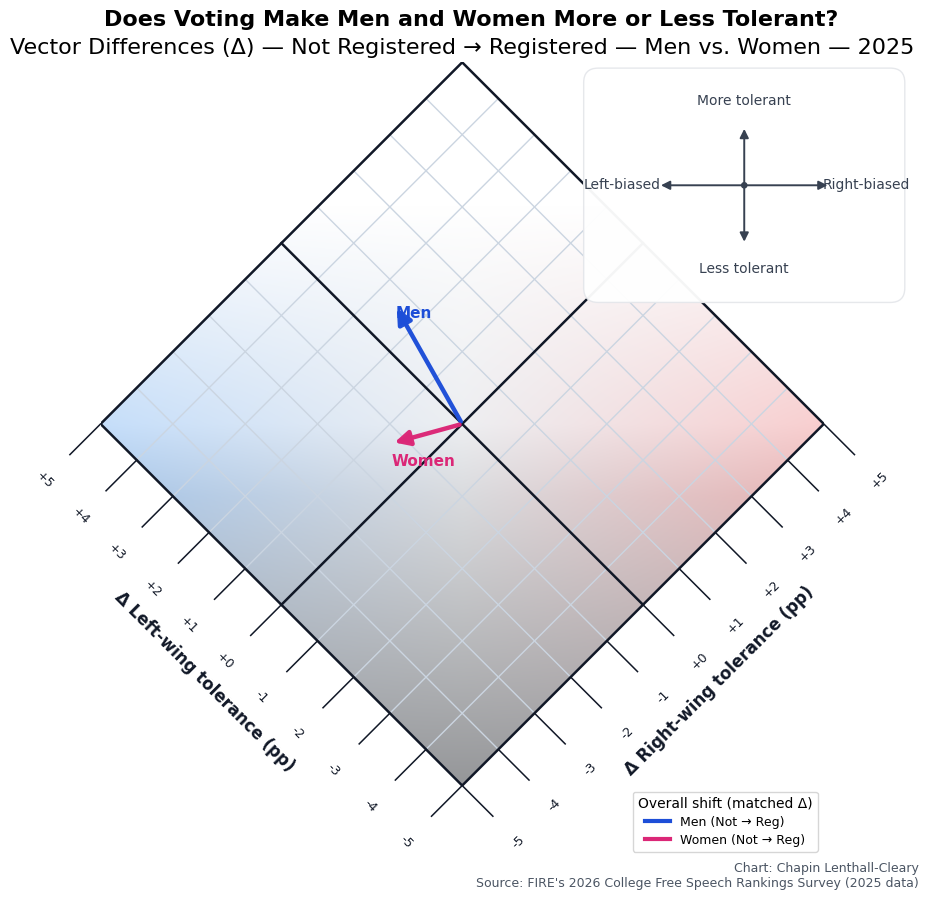

Figure saved to: /Users/chapin.lenthall-cleary/vector_deltas_diamond_NotToRegistered_MenWomen.png


In [43]:
#!/usr/bin/env python3
from pathlib import Path
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch, Circle, Polygon

# ---------- Config ----------
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

FULL_EXTENT_PP = 5                  # ±5 spans the full diamond
SCALE = 50.0 / FULL_EXTENT_PP       # L' = 50 + SCALE*ΔL ; R' = 50 + SCALE*ΔR

# --- Compass sizing/position (Code 2 styling) ---
BASE_COMPASS_W     = 0.30
BASE_COMPASS_H     = 0.30
H_EXPAND_PP        = 0.12
COMPASS_W   = BASE_COMPASS_W + H_EXPAND_PP
COMPASS_H   = BASE_COMPASS_H
COMPASS_PAD = 0.02
COMPASS_SHIFT = -0.12

# Triads
RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

def scale_triad_to_pct(sum_vals: pd.Series, k: int = 3) -> pd.Series:
    return (sum_vals - k) / (3 * k) * 100.0

def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")
    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)
    ideo = np.where(valid_fire, fire, np.where(valid_cp, cp, np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")

# ---------- Diamond mapping (Code 2 geometry) ----------
P0 = np.array([50.0, 0.0])
VL = np.array([-50.0, 50.0])
VR = np.array([ 50.0, 50.0])

def to_diamond(L, R):
    sL, sR = np.asarray(L)/100.0, np.asarray(R)/100.0
    xy = P0 + sL*VL + sR*VR
    return float(xy[0]), float(xy[1])

# ---------- Background ----------
def _add_2d_gradient_bg(ax, diamond_outline, *, nx=800, ny=800):
    x = np.linspace(0.0, 1.0, nx); y = np.linspace(0.0, 1.0, ny)
    X, Y = np.meshgrid(x, y)
    c_left, c_mid, c_right = np.array(to_rgb("#93c5fd")), np.array(to_rgb("#e5e7eb")), np.array(to_rgb("#fca5a5"))
    H = np.zeros((ny, nx, 3), dtype=float)
    uL, uR = np.clip(2*X, 0, 1), np.clip(2*(X - 0.5), 0, 1)
    for ch in range(3):
        H[..., ch] = np.where(X <= 0.5, (1-uL)*c_left[ch]+uL*c_mid[ch], (1-uR)*c_mid[ch]+uR*c_right[ch])
    white, gray = np.array(to_rgb("#ffffff")), np.array(to_rgb("#e5e7eb"))
    t = np.clip(Y/0.80, 0, 1)
    V = (1-t)[..., None]*gray + t[..., None]*white
    bell = 1.0 - np.abs(2*t - 1.0); alpha = 0.65*bell
    IMG = (1-alpha)[..., None]*V + alpha[..., None]*H
    shade_strength = np.clip((0.5 - Y)/0.5, 0.0, 1.0); IMG *= (1.0 - 0.35*shade_strength[..., None])
    IMG = np.clip(IMG, 0.0, 1.0); IMG[Y >= 0.85] = white
    im = ax.imshow(IMG, origin="lower", extent=[0, 100, 0, 100], interpolation="bilinear", zorder=-10)
    im.set_clip_path(diamond_outline)

# ---------- Compass ----------
def add_compass(ax, *, width, height, pad=0.02, shift_left, directions_deg, labels):
    cx = 1 - pad - width/2 - shift_left; cy = 1 - pad - height/2
    box = FancyBboxPatch((cx - width/2, cy - height/2), width, height,
                         transform=ax.transAxes, boxstyle="round,pad=0.012,rounding_size=0.02",
                         linewidth=1.0, facecolor="white", edgecolor="#e5e7eb", alpha=0.96, zorder=8)
    box.set_clip_on(False); ax.add_patch(box)
    def r_max(th, w=width, h=height): ct, st = abs(np.cos(th)), abs(np.sin(th)); ct=max(ct,1e-9); st=max(st,1e-9); return min((w/2-0.06*min(w,h))/ct, (h/2-0.06*min(w,h))/st)
    color="#374151"; lw=1.4; ms=13; fz=10.0
    for angle_deg, label in zip(directions_deg, labels):
        th = np.deg2rad(angle_deg); rmax = r_max(th); r_arrow = 0.62*rmax; r_label = 0.88*rmax
        x_tip, y_tip = cx + r_arrow*np.cos(th), cy + r_arrow*np.sin(th)
        arr = FancyArrowPatch((cx, cy), (x_tip, y_tip), transform=ax.transAxes,
                              arrowstyle="-|>", mutation_scale=ms, linewidth=lw, color=color, zorder=9)
        arr.set_clip_on(False); ax.add_patch(arr)
        txt = ax.text(cx + r_label*np.cos(th), cy + r_label*np.sin(th), label, transform=ax.transAxes,
                      ha="center", va="center", fontsize=fz, color=color, zorder=10)
        txt.set_clip_on(False)
    center = Circle((cx, cy), radius=min(width, height)*0.012, transform=ax.transAxes, color=color, zorder=10)
    center.set_clip_on(False); ax.add_patch(center)

# ---------- Geometry helpers ----------
def _ray_intersect_polygon(pt, ray_dir, poly_xy):
    p = np.asarray(pt, float); r = np.asarray(ray_dir, float); s_min = np.inf; eps = 1e-9
    for i in range(len(poly_xy)):
        a = np.asarray(poly_xy[i], float); b = np.asarray(poly_xy[(i+1)%len(poly_xy)], float)
        svec = b - a
        M = np.array([[r[0], -svec[0]], [r[1], -svec[1]]], float); rhs = a - p
        det = M[0,0]*M[1,1] - M[0,1]*M[1,0]
        if abs(det) < eps: continue
        invM = (1.0/det)*np.array([[ M[1,1], -M[0,1]], [-M[1,0],  M[0,0]]], float)
        s, t = invM @ rhs
        if s >= -eps and -eps <= t <= 1+eps: s_min = min(s_min, s)
    return s_min

# ---------- Δ axes (labels & numbers OUTSIDE; label moved down & toward center) ----------
def draw_delta_axis_with_outside_labels(
    ax, diamond_xy, *, axis_kind, full_extent_pp, ticks_pp,
    tick_len=6.0, label_offset_out=12.0, tick_label_offset_out=7.0,
    label_frac=0.62, rotate_extra_deg=0.0, label_text=""
):
    """
    Δ axis through center with tick marks & labels OUTSIDE the diamond.

    Changes vs previous:
    - If (axis_kind == "L") and the tick value is exactly -full_extent_pp and that tick
      lands on the *left side* of the plot, do NOT add the +180° rotation (fixes the
      left -5 label only). All other labels keep their previous rotation behavior.
    - Both left *and right* tick-labels get the same "closer" nudge (−2.0) so the
      right side now matches the left side’s proximity to the diamond.
    """
    # Endpoints along the Δ axis (proxy in absolute coords)
    if axis_kind == "L":
        L0, R0 = 50 - SCALE*full_extent_pp, 50
        L1, R1 = 50 + SCALE*full_extent_pp, 50
    else:
        L0, R0 = 50, 50 - SCALE*full_extent_pp
        L1, R1 = 50, 50 + SCALE*full_extent_pp

    x0, y0 = to_diamond(L0, R0)
    x1, y1 = to_diamond(L1, R1)
    ax.plot([x0, x1], [y0, y1], color="#111827", linewidth=1.8, zorder=4)

    # Axis direction + outward (below) normal
    v = np.array([x1 - x0, y1 - y0], float)
    L_v = float(np.hypot(v[0], v[1])); u = v / L_v if L_v else np.array([1.0, 0.0])
    n_cw, n_ccw = np.array([ u[1], -u[0]]), np.array([-u[1],  u[0]])
    n = n_cw if n_cw[1] < n_ccw[1] else n_ccw
    base_angle = np.degrees(np.arctan2(v[1], v[0]))

    # Use the same "closer" nudge for BOTH sides now
    closer_nudge = -2.0

    # Ticks every 1 pp, placed outside; special-case LEFT -full_extent tick rotation
    for t in ticks_pp:
        if axis_kind == "L":
            Lt, Rt = 50 + SCALE*t, 50
        else:
            Lt, Rt = 50, 50 + SCALE*t

        xt, yt = to_diamond(Lt, Rt)

        # Project to boundary along outward normal
        s_out = _ray_intersect_polygon((xt, yt), n, diamond_xy)
        xb, yb = (xt + n[0]*s_out, yt + n[1]*s_out)

        # Tick mark outside
        xe, ye = (xb + n[0]*tick_len, yb + n[1]*tick_len)
        ax.plot([xb, xe], [yb, ye], color="#111827", linewidth=1.1, zorder=4, clip_on=False)

        # Determine side for rotation (same rule as before)
        on_left_side = (xb < 50.0)

        # Default rotation (keep current behavior)
        angle = base_angle + (180.0 if on_left_side else 0.0)

        # ✅ Force ONLY the left ΔLeft-axis -full_extent tick (i.e., -5) to 180°
        if axis_kind == "L" and t == -full_extent_pp:
            angle = base_angle + 180.0


        # SPECIAL CASE: fix only the left-side "-full_extent" tick on the ΔLeft axis
        if axis_kind == "L" and on_left_side and (t == -full_extent_pp):
            angle = base_angle  # undo the +180° for this one tick only

        # Apply the "closer" nudge on BOTH sides now
        offset = tick_label_offset_out + closer_nudge

        xlbl, ylbl = (xb + n[0]*(tick_len + offset),
                      yb + n[1]*(tick_len + offset))
        ax.text(xlbl, ylbl, f"{t:+d}", ha="center", va="center",
                fontsize=9, color="#111827",
                rotation=angle, rotation_mode="anchor",
                zorder=5, clip_on=False)

    # Axis label: position along the axis near center, then push outside
    px = x0 + label_frac*(x1 - x0); py = y0 + label_frac*(y1 - y0)
    s_lab = _ray_intersect_polygon((px, py), n, diamond_xy)
    xl, yl = (px + n[0]*(s_lab + label_offset_out), py + n[1]*(s_lab + label_offset_out))
    ax.text(xl, yl, label_text, ha="center", va="center",
            fontsize=12, color="#111827", fontweight="bold",
            rotation=base_angle + rotate_extra_deg, rotation_mode="anchor",
            zorder=5, clip_on=False)




# ---------- Δ-gridlines ----------
def draw_delta_grid(ax, diamond_outline, span_pp=FULL_EXTENT_PP, step_pp=1):
    grid_artists = []
    light_line = "#cbd5e1"; heavy_line = "#94a3b8"
    vals = list(range(-span_pp, span_pp+1, step_pp))
    for v in vals:
        Lp = 50 + SCALE*v; Rp = 50 + SCALE*v
        # constant L' line
        x1, y1 = to_diamond(Lp, 0); x2, y2 = to_diamond(Lp, 100)
        color = heavy_line if (v % 5 == 0) else light_line
        ln1, = ax.plot([x1, x2], [y1, y2], color=color, linewidth=1.0, zorder=0)
        # constant R' line
        x3, y3 = to_diamond(0, Rp); x4, y4 = to_diamond(100, Rp)
        ln2, = ax.plot([x3, x4], [y3, y4], color=color, linewidth=1.0, zorder=0)
        grid_artists += [ln1, ln2]
    for art in grid_artists: art.set_clip_path(diamond_outline)

# ---------- Data prep & matched-delta ----------
def load_and_filter(csv_path: Path, year: int) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(f"Data file not found at: {csv_path.resolve()}")
    df = pd.read_csv(csv_path, low_memory=False)
    for col in ["datayear", "gender_bin", "regvoter", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["ideo"] = build_ideo_like_code(df)
    df = df[(df["datayear"] == year) & (df["gender_bin"].isin([1, 2])) &
            (df["regvoter"].isin([0, 1])) & (df["ideo"].isin(range(1, 12)))].copy()
    in_range_spk = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range_spk.all(axis=1)].copy()
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))
    return df

def compute_group_means(df: pd.DataFrame) -> pd.DataFrame:
    return (df.groupby(["ideo", "gender_bin", "regvoter"], dropna=True)
              .agg(left_avg=("left_pct", "mean"),
                   right_avg=("right_pct", "mean"),
                   n=("left_pct", "size"))
              .reset_index())

def compute_overall_delta_for_gender(stats: pd.DataFrame, gender_code: int,
                                     base_reg: int = 0, target_reg: int = 1) -> Optional[dict]:
    s = stats[stats["gender_bin"] == gender_code]
    if s.empty: return None
    x_pivot = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    y_pivot = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_pivot = s.pivot(index="ideo", columns="regvoter", values="n")
    for p in (x_pivot, y_pivot, n_pivot):
        if base_reg not in p.columns or target_reg not in p.columns: return None
    x_pair = x_pivot[[base_reg, target_reg]].dropna()
    y_pair = y_pivot[[base_reg, target_reg]].dropna()
    n_pair = n_pivot[[base_reg, target_reg]].dropna()
    common = x_pair.index.intersection(y_pair.index).intersection(n_pair.index)
    if len(common) == 0: return None
    dx = (x_pair.loc[common, target_reg] - x_pair.loc[common, base_reg]).astype(float)
    dy = (y_pair.loc[common, target_reg] - y_pair.loc[common, base_reg]).astype(float)
    w  = np.minimum(n_pair.loc[common, base_reg], n_pair.loc[common, target_reg]).astype(float)
    mask = (w > 0) & dx.notna() & dy.notna()
    if not mask.any(): return None
    sel = w.index[mask]
    return {
        "delta_L": float(np.average(dx.loc[sel], weights=w.loc[sel])),
        "delta_R": float(np.average(dy.loc[sel], weights=w.loc[sel])),
        "n_base":  int(n_pair.loc[sel, base_reg].sum()),
        "n_target":int(n_pair.loc[sel, target_reg].sum()),
    }

# ---------- Plot ----------
def make_overall_delta_diamond_plot(men_delta: dict, women_delta: dict, year: int):
    fig, ax = plt.subplots(figsize=(11.2, 11.0))

    diamond_xy = np.array([[50, 100], [100, 50], [50, 0], [0, 50]], dtype=float)
    diamond_outline = Polygon(diamond_xy, closed=True, facecolor="none",
                              edgecolor="#111827", linewidth=1.8, zorder=3, joinstyle="miter")
    ax.add_patch(diamond_outline)

    _add_2d_gradient_bg(ax, diamond_outline)

    for sp in ax.spines.values(): sp.set_visible(False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(0, 100); ax.set_ylim(0, 100)
    ax.set_aspect("equal", adjustable="box")

    # Δ gridlines
    draw_delta_grid(ax, diamond_outline, span_pp=FULL_EXTENT_PP, step_pp=1)

    # Δ axes with outside ticks; labels moved "down & toward center"
    draw_delta_axis_with_outside_labels(
        ax, diamond_xy,
        axis_kind="L", full_extent_pp=FULL_EXTENT_PP,
        ticks_pp=tuple(range(-FULL_EXTENT_PP, FULL_EXTENT_PP+1, 1)),
        tick_len=6.0, label_offset_out=15.0, tick_label_offset_out=7.0,
        label_frac=0.5, rotate_extra_deg=180.0,  # rotate Left label 180°
        label_text="Δ Left-wing tolerance (pp)"
    )
    draw_delta_axis_with_outside_labels(
        ax, diamond_xy,
        axis_kind="R", full_extent_pp=FULL_EXTENT_PP,
        ticks_pp=tuple(range(-FULL_EXTENT_PP, FULL_EXTENT_PP+1, 1)),
        tick_len=6.0, label_offset_out=15.0, tick_label_offset_out=7.0,
        label_frac=0.5, rotate_extra_deg=0.0,
        label_text="Δ Right-wing tolerance (pp)"
    )

    # Center and arrows
    cx, cy = to_diamond(50, 50)
    gender_colors = {1: "#1d4ed8", 2: "#db2777"}  # men, women

    def add_arrow(delta_L, delta_R, color, label, n_base, n_target, label_offset_pts=(0,0)):
        dL = np.clip(delta_L, -FULL_EXTENT_PP, FULL_EXTENT_PP)
        dR = np.clip(delta_R, -FULL_EXTENT_PP, FULL_EXTENT_PP)
        L_end, R_end = 50 + SCALE*dL, 50 + SCALE*dR
        ex, ey = to_diamond(L_end, R_end)
        ls = "--" if min(n_base, n_target) < 40 else "-"
        arr = FancyArrowPatch((cx, cy), (ex, ey), arrowstyle="-|>",
                              mutation_scale=22, linewidth=3.2,
                              color=color, alpha=0.98, linestyle=ls, zorder=6)
        arr.set_clip_path(diamond_outline); ax.add_patch(arr)
        ax.annotate(label, (ex, ey), xytext=label_offset_pts, textcoords="offset points",
                    fontsize=11, fontweight="bold", color=color, ha="left", va="top", zorder=8)

    if men_delta is not None:
        add_arrow(men_delta["delta_L"], men_delta["delta_R"],
                  gender_colors[1], "Men", men_delta["n_base"], men_delta["n_target"],
                  label_offset_pts=(0, 0))  # leave men label as-is

    if women_delta is not None:
        add_arrow(women_delta["delta_L"], women_delta["delta_R"],
                  gender_colors[2], "Women", women_delta["n_base"], women_delta["n_target"],
                  label_offset_pts=(0, -8))  # move pink label down a bit

    # Compass
    compass_dirs  = [90, 180, 0, 270]
    compass_labels= ["More tolerant", "Left-biased", "Right-biased", "Less tolerant"]
    add_compass(ax, width=COMPASS_W, height=COMPASS_H, pad=COMPASS_PAD, shift_left=COMPASS_SHIFT,
                directions_deg=compass_dirs, labels=compass_labels)

    # Legend moved further DOWN
    handles = []
    if men_delta is not None:
        handles.append(Line2D([0],[0], color=gender_colors[1], lw=3, label="Men (Not → Reg)"))
    if women_delta is not None:
        handles.append(Line2D([0],[0], color=gender_colors[2], lw=3, label="Women (Not → Reg)"))
    if handles:
        ax.legend(handles=handles, title="Overall shift (matched Δ)",
                  frameon=True, fontsize=9, title_fontsize=10, borderpad=0.4, labelspacing=0.4,
                  loc="lower right", bbox_to_anchor=(1.0, -0.1), bbox_transform=ax.transAxes)

    ax.set_title(f"Vector Differences (Δ) — Not Registered → Registered — Men vs. Women — {year}",
                 fontsize=16)
    fig = ax.figure
    fig.suptitle("Does Voting Make Men and Women More or Less Tolerant?",
                 fontsize=16, fontweight="bold", y=0.9)
    fig.text(0.9, 0.1,
             "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)",
             ha="right", va="bottom", fontsize=9, color="#4b5563")

    fig.tight_layout(rect=[0.02, 0.11, 0.98, 0.92])
    out_path = Path("vector_deltas_diamond_NotToRegistered_MenWomen.png")
    fig.savefig(out_path, dpi=220)
    plt.show()
    print(f"Figure saved to: {out_path.resolve()}")

# ---------- Main ----------
def main():
    df = load_and_filter(CSV_PATH, YEAR)
    stats = compute_group_means(df)
    men_delta   = compute_overall_delta_for_gender(stats, gender_code=1)
    women_delta = compute_overall_delta_for_gender(stats, gender_code=2)
    if men_delta is None and women_delta is None:
        raise SystemExit("No matched-delta overall deltas available for Men or Women.")
    make_overall_delta_diamond_plot(men_delta, women_delta, YEAR)

if __name__ == "__main__":
    main()


In [45]:
#!/usr/bin/env python3
"""
Compute share of respondents in four categories for Left- vs Right-wing tolerance,
broken out by Gender (Men/Women) × Registration (Not registered / Registered).

Categories:
  1) Perfect: 100% for BOTH tolerances  -> right_sum==12 and left_sum==12
  2) "Left-wing witches": 0% Right AND nonzero Left -> right_sum==3 and left_sum>3
  3) Vice versa ("Right-wing witches"): 0% Left AND nonzero Right -> left_sum==3 and right_sum>3
  4) Exactly 1/3 for BOTH tolerances -> right_sum==6 and left_sum==6
     (since scaling maps triad sums 3..12 to 0..100, 1/3 corresponds to sum==6)

Outputs a CSV: tolerance_summary_by_gender_reg.csv
and prints a formatted table to stdout.
"""

import pandas as pd
import numpy as np
from pathlib import Path

# --- Config ---
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025
GENDER_LABELS = {1: "Men", 2: "Women"}
REG_LABELS = {0: "Not registered", 1: "Registered"}

# Keep your original triads/naming
RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]          # "Right-wing Speakers"
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]  # "Left-wing Speakers"
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD


def compute_group_percents(df: pd.DataFrame) -> pd.DataFrame:
    """
    df is filtered to one survey year, gender_bin in {1,2}, regvoter in {0,1}, and all spk_* in [1,4].
    Returns a DataFrame with one row per group and the requested percentages.
    """
    out_rows = []

    # Precompute triad sums (integers)
    df = df.copy()
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)

    for g in [1, 2]:
        for r in [0, 1]:
            sub = df[(df["gender_bin"] == g) & (df["regvoter"] == r)]
            n = len(sub)
            if n == 0:
                row = {
                    "Group": f"{GENDER_LABELS[g]} — {REG_LABELS[r]}",
                    "n": 0,
                    "Percent perfect (100% both)": 0.0,
                    "Percent left-wing witches (0% Right & >0 Left)": 0.0,
                    "Percent right-wing witches (0% Left & >0 Right)": 0.0,
                    "Percent at 1/3 on both": 0.0,
                }
                out_rows.append(row)
                continue

            # Conditions based on exact triad sums:
            # sums range 3..12; 12 -> 100%, 3 -> 0%, 6 -> 33.33...%
            perfect = (sub["right_sum"] == 12) & (sub["left_sum"] == 12)
            left_witches  = (sub["right_sum"] == 3) & (sub["left_sum"] > 3)
            right_witches = (sub["left_sum"] == 3) & (sub["right_sum"] > 3)
            one_third_both = (sub["right_sum"] == 6) & (sub["left_sum"] == 6)

            row = {
                "Group": f"{GENDER_LABELS[g]} — {REG_LABELS[r]}",
                "n": n,
                "Percent perfect (100% both)": round(100 * perfect.mean(), 1),
                "Percent left-wing witches (0% Right & >0 Left)": round(100 * left_witches.mean(), 1),
                "Percent right-wing witches (0% Left & >0 Right)": round(100 * right_witches.mean(), 1),
                "Percent at 1/3 on both": round(100 * one_third_both.mean(), 1),
            }
            out_rows.append(row)

    cols = [
        "Group", "n",
        "Percent perfect (100% both)",
        "Percent left-wing witches (0% Right & >0 Left)",
        "Percent right-wing witches (0% Left & >0 Right)",
        "Percent at 1/3 on both",
    ]
    return pd.DataFrame(out_rows, columns=cols)


def main():
    # Load
    df = pd.read_csv(CSV_PATH, low_memory=False)

    # Coerce relevant columns to numeric
    numeric_cols = ["datayear", "gender_bin", "regvoter", *SPK_ALL]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to target year, men/women only, and registration in {0,1}
    df = df[(df["datayear"] == YEAR) & (df["gender_bin"].isin([1, 2])) & (df["regvoter"].isin([0, 1]))]
    if df.empty:
        raise SystemExit(f"No rows found for datayear == {YEAR}, gender_bin in [1,2], and regvoter in [0,1].")

    # Require ALL six spk_* in [1,4], matching your earlier scripts
    in_range = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range.all(axis=1)].copy()
    if df.empty:
        raise SystemExit("No rows remain after requiring all six spk_* to be in [1,4].")

    # Compute and save table
    table = compute_group_percents(df)
    out_csv = Path("tolerance_summary_by_gender_reg.csv")
    table.to_csv(out_csv, index=False)

    # Pretty print
    with pd.option_context("display.max_colwidth", None, "display.width", 120):
        print(table.to_string(index=False))
    print(f"\nSaved: {out_csv.resolve()}")


if __name__ == "__main__":
    main()


                 Group     n  Percent perfect (100% both)  Percent left-wing witches (0% Right & >0 Left)  Percent right-wing witches (0% Left & >0 Right)  Percent at 1/3 on both
  Men — Not registered  5064                          4.7                                             5.5                                              5.5                    10.8
      Men — Registered 19350                          6.9                                             7.0                                              5.2                     8.2
Women — Not registered  6340                          1.9                                            17.9                                              4.2                     9.9
    Women — Registered 34476                          1.8                                            23.0                                              4.0                     7.0

Saved: /Users/chapin.lenthall-cleary/tolerance_summary_by_gender_reg.csv


                 Group     n  Percent perfect (100% both)  Percent "Woke" (0% Right & >0 Left)
  Men — Not registered  5064                          4.7                                  5.5
      Men — Registered 19350                          6.9                                  7.0
Women — Not registered  6340                          1.9                                 17.9
    Women — Registered 34476                          1.8                                 23.0

Saved: tolerance_summary_by_gender_reg_FIRST_TWO.csv


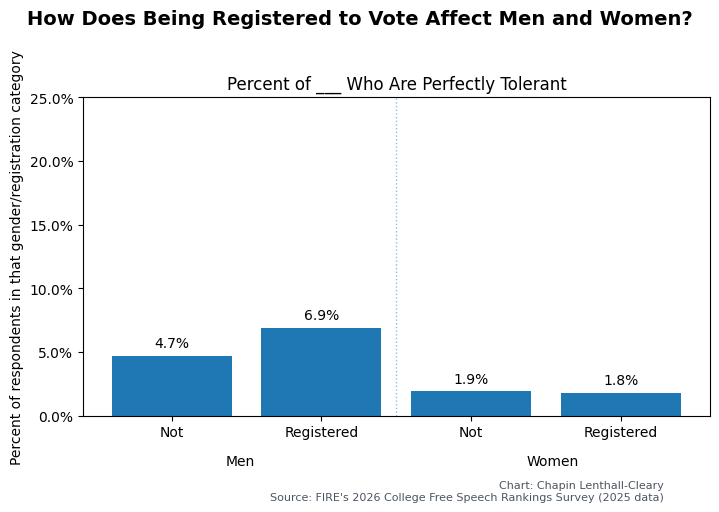

Saved: /Users/chapin.lenthall-cleary/bar_percent_perfect.png


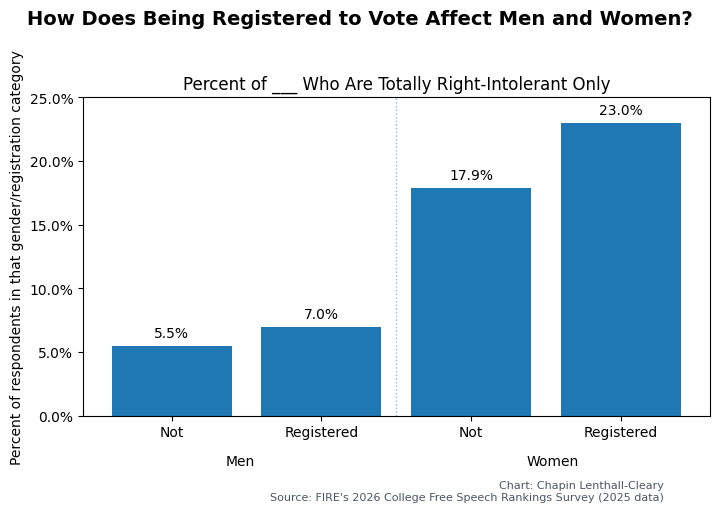

Saved: /Users/chapin.lenthall-cleary/bar_percent_woke.png


In [57]:
#!/usr/bin/env python3
"""
Two bar charts (4 bars each) for:
  1) Percent Perfect
  2) Percent "Woke"

Bar order (left→right): Men Not, Men Registered, Women Not, Women Registered.
Y-axis fixed at 0–25% with label:
  "Percent of respondents in that gender/registration category"

Each figure has a Code 2–style suptitle and credit block.

Saves:
  bar_percent_perfect.png
  bar_percent_woke.png
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path

# --- Config ---
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025
GENDER_LABELS = {1: "Men", 2: "Women"}
REG_LABELS = {0: "Not registered", 1: "Registered"}

RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

SUPTITLE_TEXT = "How Does Being Registered to Vote Affect Men and Women?"
CREDITS_TEXT  = "Chart: Chapin Lenthall-Cleary\nSource: FIRE's 2026 College Free Speech Rankings Survey (2025 data)"

def compute_group_percents(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)

    rows = []
    for g in [1, 2]:
        for r in [0, 1]:
            sub = df[(df["gender_bin"] == g) & (df["regvoter"] == r)]
            n = len(sub)

            perfect = (sub["right_sum"] == 12) & (sub["left_sum"] == 12)
            woke    = (sub["right_sum"] == 3)  & (sub["left_sum"] > 3)

            rows.append({
                "Group": f"{GENDER_LABELS[g]} — {REG_LABELS[r]}",
                "n": n,
                "Percent perfect (100% both)": round(100 * perfect.mean(), 1) if n else 0.0,
                'Percent "Woke" (0% Right & >0 Left)': round(100 * woke.mean(), 1) if n else 0.0,
            })

    return pd.DataFrame(rows, columns=[
        "Group", "n",
        "Percent perfect (100% both)",
        'Percent "Woke" (0% Right & >0 Left)',
    ])

def plot_category_bar_chart(df_summary: pd.DataFrame, value_col: str, title: str, filename: str):
    """
    One chart, four bars, ordered: Men Not, Men Registered, Women Not, Women Registered.
    Includes Code 2–style suptitle and credit block.
    """
    order = [
        "Men — Not registered",
        "Men — Registered",
        "Women — Not registered",
        "Women — Registered",
    ]
    present = [g for g in order if g in df_summary["Group"].tolist()]
    if len(present) < 4:
        present = df_summary["Group"].tolist()

    vals = df_summary.set_index("Group").loc[present, value_col].values
    xlabels = ["Not", "Registered", "Not", "Registered"][:len(present)]

    fig = plt.figure(figsize=(7.6, 5.6))
    ax = plt.gca()
    x = np.arange(len(present))
    bars = ax.bar(x, vals)

    # Axes formatting
    ax.set_title(title)
    ax.set_xticks(x, xlabels)
    ax.set_ylim(0, 25)
    ax.set_ylabel("Percent of respondents in that gender/registration category")
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

    # Group headers + divider
    ax.text(0.25, -0.12, "Men", transform=ax.transAxes, ha="center", va="top")
    ax.text(0.75, -0.12, "Women", transform=ax.transAxes, ha="center", va="top")
    ax.axvline(1.5, linestyle=":", linewidth=1, alpha=0.5)

    # Value labels
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.1f}%",
                    xy=(b.get_x() + b.get_width()/2, h),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha="center", va="bottom")

    # --- Code 2–style title & credits ---
    fig.suptitle(SUPTITLE_TEXT, fontsize=14, fontweight="bold", y=0.93)
    fig.text(
        0.9, .05,
        CREDITS_TEXT,
        ha="right", va="bottom", fontsize=8, color="#4b5563"
    )

    # Leave space for the suptitle/credits
    fig.tight_layout(rect=[0.02, 0.06, 0.98, 0.90])

    out = Path(filename)
    fig.savefig(out, dpi=150)
    plt.show()
    print(f"Saved: {out.resolve()}")

def main():
    df = pd.read_csv(CSV_PATH, low_memory=False)

    # Coerce relevant columns to numeric
    numeric_cols = ["datayear", "gender_bin", "regvoter", *SPK_ALL]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to year, gender in {1,2}, reg in {0,1}, and all spk_* in [1,4]
    df = df[(df["datayear"] == YEAR) & (df["gender_bin"].isin([1, 2])) & (df["regvoter"].isin([0, 1]))]
    in_range = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range.all(axis=1)].copy()
    if df.empty:
        raise SystemExit("No valid rows after filtering.")

    summary = compute_group_percents(df)
    summary.to_csv("tolerance_summary_by_gender_reg_FIRST_TWO.csv", index=False)
    print(summary.to_string(index=False))
    print("\nSaved: tolerance_summary_by_gender_reg_FIRST_TWO.csv")

    # Two charts (only the first two categories), y-axis 0–25%
    plot_category_bar_chart(
        summary,
        "Percent perfect (100% both)",
        "Percent of ___ Who Are Perfectly Tolerant",
        "bar_percent_perfect.png",
    )
    plot_category_bar_chart(
        summary,
        'Percent "Woke" (0% Right & >0 Left)',
        'Percent of ___ Who Are Totally Right-Intolerant Only',
        "bar_percent_woke.png",
    )

if __name__ == "__main__":
    main()


In [ ]:
#additional useful plots not included


=== Cohort: All ages (min_age=None, max_age=None) ===

Sample size by registration — Men — All ages
Registration status     N
     Not registered  5064
         Registered 19350

Δ (Left, Right) — Men — All ages — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,6.03,-4.33,7.42,311,2172
1,2,Somewhat liberal,3.34,0.03,3.34,662,3221
2,3,Slightly liberal,2.55,1.29,2.85,518,2146
3,4,"Moderate, middle-of-the-road",1.63,1.40,2.15,1015,3126
4,5,Slightly conservative,2.66,2.18,3.44,445,1718
5,6,Somewhat conservative,2.54,1.14,2.79,527,2746
6,7,Very conservative,-0.55,5.23,5.26,195,1453
7,8,Democratic Socialist,5.55,-4.32,7.04,168,473
8,9,Libertarian,7.54,10.98,13.32,108,285
9,10,Haven't thought much about this,0.16,-1.80,1.80,884,1487


Saved: vectors_left_right_NotToRegistered_Men_AllAges_2025.png


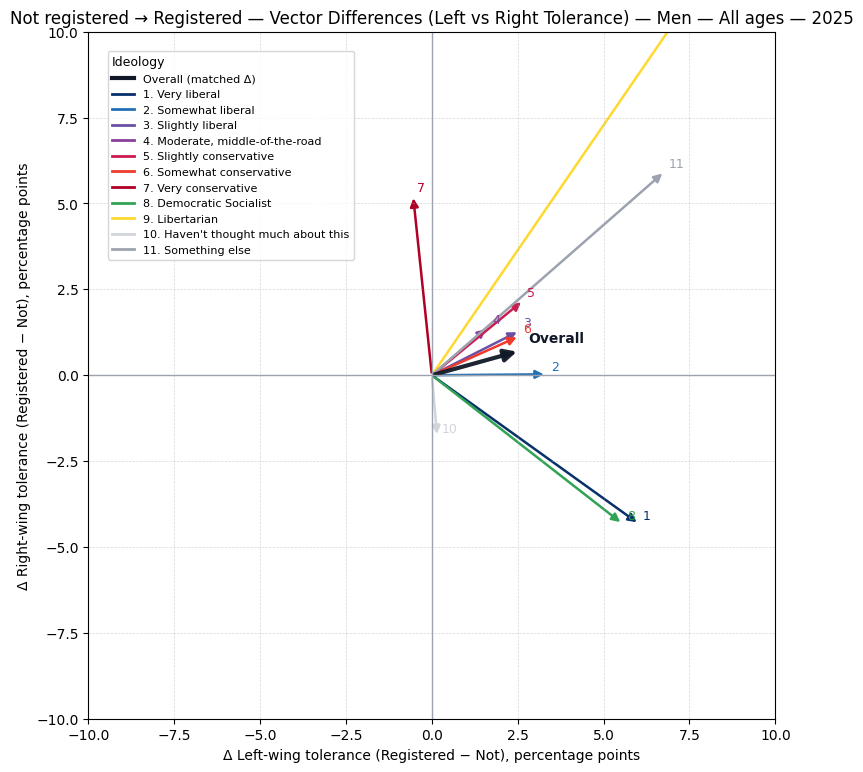


Sample size by registration — Women — All ages
Registration status     N
     Not registered  6340
         Registered 34476

Δ (Left, Right) — Women — All ages — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,4.97,-3.19,5.90,671,7630
1,2,Somewhat liberal,1.41,-0.82,1.63,1340,9927
2,3,Slightly liberal,-1.12,-1.80,2.12,706,3523
3,4,"Moderate, middle-of-the-road",-0.70,-1.31,1.48,1055,4200
4,5,Slightly conservative,-4.10,-2.45,4.78,333,1548
5,6,Somewhat conservative,-0.61,0.92,1.11,437,2687
6,7,Very conservative,-2.40,-2.40,3.39,169,1619
7,8,Democratic Socialist,10.13,-2.79,10.50,195,658
8,9,Libertarian,5.82,3.12,6.60,109,270
9,10,Haven't thought much about this,-0.46,-0.73,0.86,1068,1825


Saved: vectors_left_right_NotToRegistered_Women_AllAges_2025.png


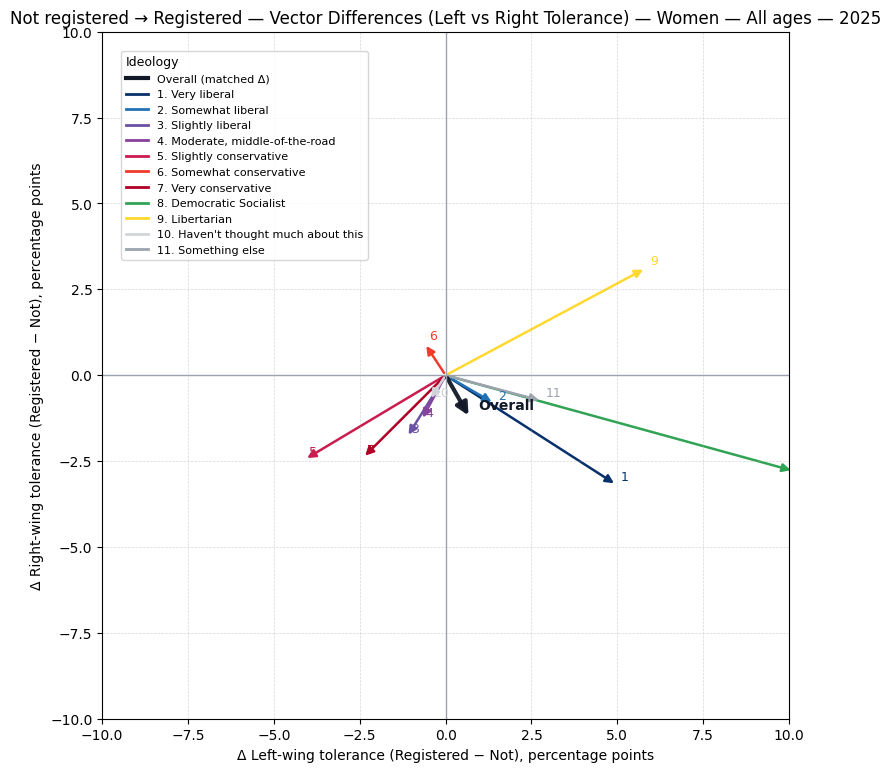


=== Cohort: Age ≥20 (min_age=20, max_age=None) ===

Sample size by registration — Men — Age ≥20
Registration status     N
     Not registered  2779
         Registered 11442

Δ (Left, Right) — Men — Age ≥20 — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,4.25,-7.00,8.19,185,1348
1,2,Somewhat liberal,3.75,-1.29,3.97,364,1881
2,3,Slightly liberal,1.69,0.68,1.82,286,1265
3,4,"Moderate, middle-of-the-road",2.20,2.25,3.15,541,1850
4,5,Slightly conservative,2.80,2.22,3.57,250,1049
5,6,Somewhat conservative,1.02,-0.23,1.04,312,1613
6,7,Very conservative,-2.20,3.22,3.90,98,867
7,8,Democratic Socialist,7.37,-4.36,8.56,99,287
8,9,Libertarian,9.46,10.39,14.05,61,172
9,10,Haven't thought much about this,1.73,-1.40,2.22,445,789


Saved: vectors_left_right_NotToRegistered_Men_Age20Plus_2025.png


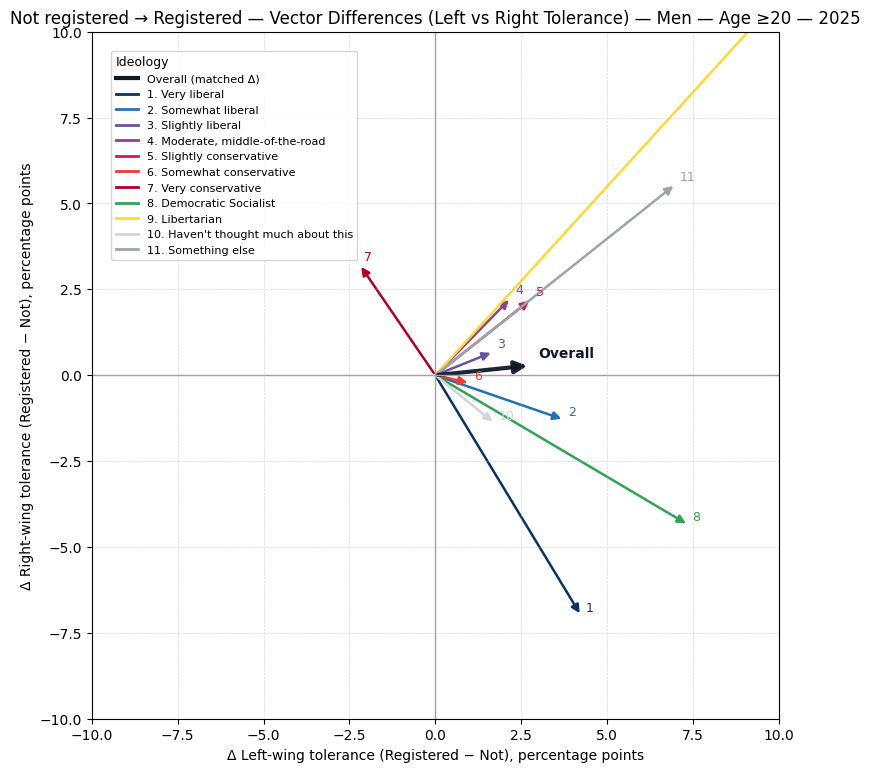


Sample size by registration — Women — Age ≥20
Registration status     N
     Not registered  3222
         Registered 19601

Δ (Left, Right) — Women — Age ≥20 — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,4.63,-3.20,5.63,378,4667
1,2,Somewhat liberal,2.12,-0.49,2.18,666,5620
2,3,Slightly liberal,0.32,-0.35,0.48,363,2019
3,4,"Moderate, middle-of-the-road",-1.68,-1.17,2.05,538,2352
4,5,Slightly conservative,-5.95,-6.44,8.77,166,896
5,6,Somewhat conservative,-2.37,-0.51,2.42,211,1427
6,7,Very conservative,-0.68,0.61,0.91,83,862
7,8,Democratic Socialist,8.47,-4.83,9.76,100,392
8,9,Libertarian,10.73,8.09,13.43,59,155
9,10,Haven't thought much about this,-1.64,-2.42,2.93,503,874


Saved: vectors_left_right_NotToRegistered_Women_Age20Plus_2025.png


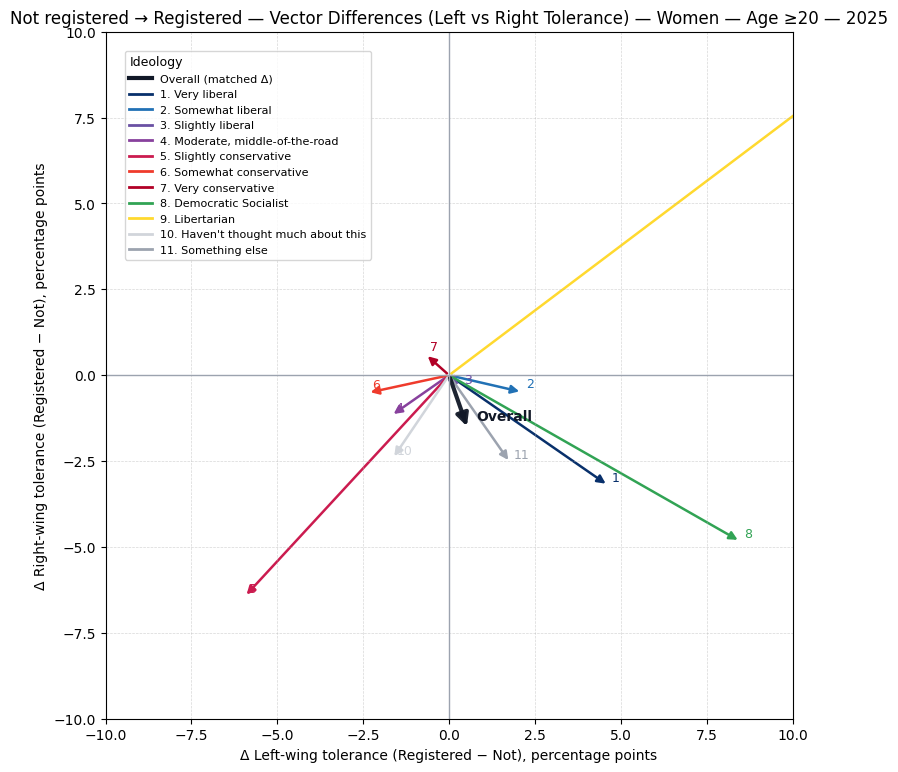


=== Cohort: Age ≤19 (min_age=None, max_age=19) ===

Sample size by registration — Men — Age ≤19
Registration status    N
     Not registered 2130
         Registered 7509

Δ (Left, Right) — Men — Age ≤19 — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,6.89,-1.80,7.12,112,774
1,2,Somewhat liberal,2.93,1.73,3.40,278,1275
2,3,Slightly liberal,2.81,1.93,3.41,220,828
3,4,"Moderate, middle-of-the-road",0.32,-0.06,0.33,436,1207
4,5,Slightly conservative,2.68,2.47,3.64,177,638
5,6,Somewhat conservative,4.92,3.10,5.82,209,1097
6,7,Very conservative,-0.34,7.15,7.15,92,568
7,8,Democratic Socialist,2.96,-3.91,4.90,67,179
8,9,Libertarian,6.52,13.75,15.22,42,100
9,10,Haven't thought much about this,-1.11,-1.81,2.12,411,657


Saved: vectors_left_right_NotToRegistered_Men_Age19AndUnder_2025.png


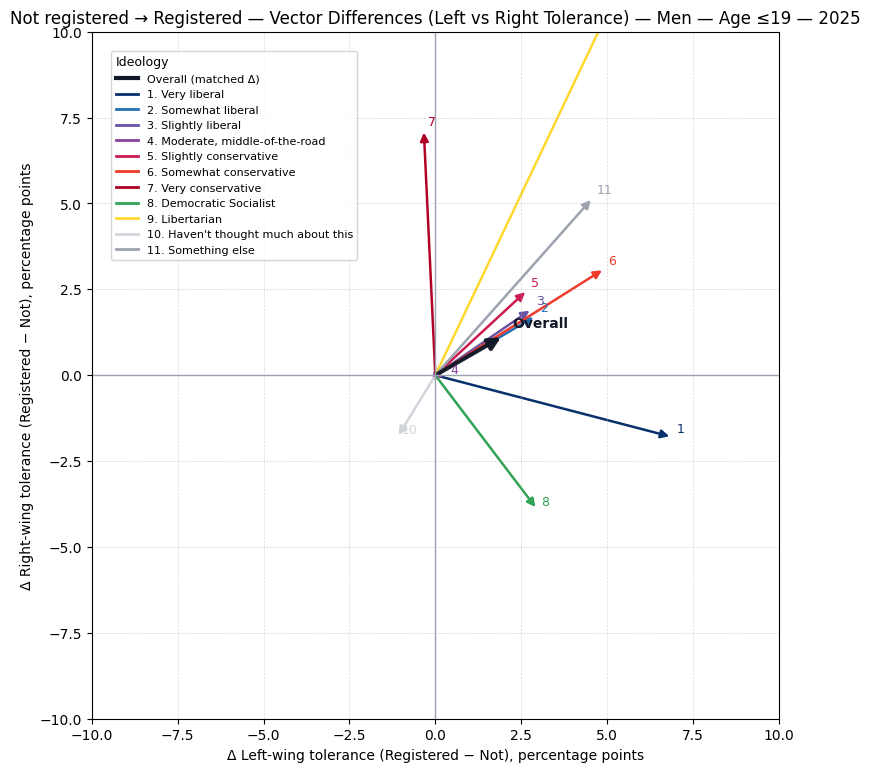


Sample size by registration — Women — Age ≤19
Registration status     N
     Not registered  2902
         Registered 14195

Δ (Left, Right) — Women — Age ≤19 — Not registered → Registered


,ideo,Ideology label,delta_x,delta_y,magnitude,n_base,n_target
0,1,Very liberal,4.96,-3.50,6.07,270,2831
1,2,Somewhat liberal,0.49,-0.88,1.01,628,4154
2,3,Slightly liberal,-2.33,-3.64,4.32,319,1443
3,4,"Moderate, middle-of-the-road",0.68,-1.30,1.47,473,1741
4,5,Slightly conservative,-2.32,1.91,3.01,158,615
5,6,Somewhat conservative,0.95,2.30,2.49,219,1225
6,7,Very conservative,-2.45,-4.89,5.47,79,729
7,8,Democratic Socialist,9.88,-1.05,9.94,90,244
8,9,Libertarian,-0.35,-2.50,2.52,43,102
9,10,Haven't thought much about this,0.04,0.43,0.43,528,892


Saved: vectors_left_right_NotToRegistered_Women_Age19AndUnder_2025.png


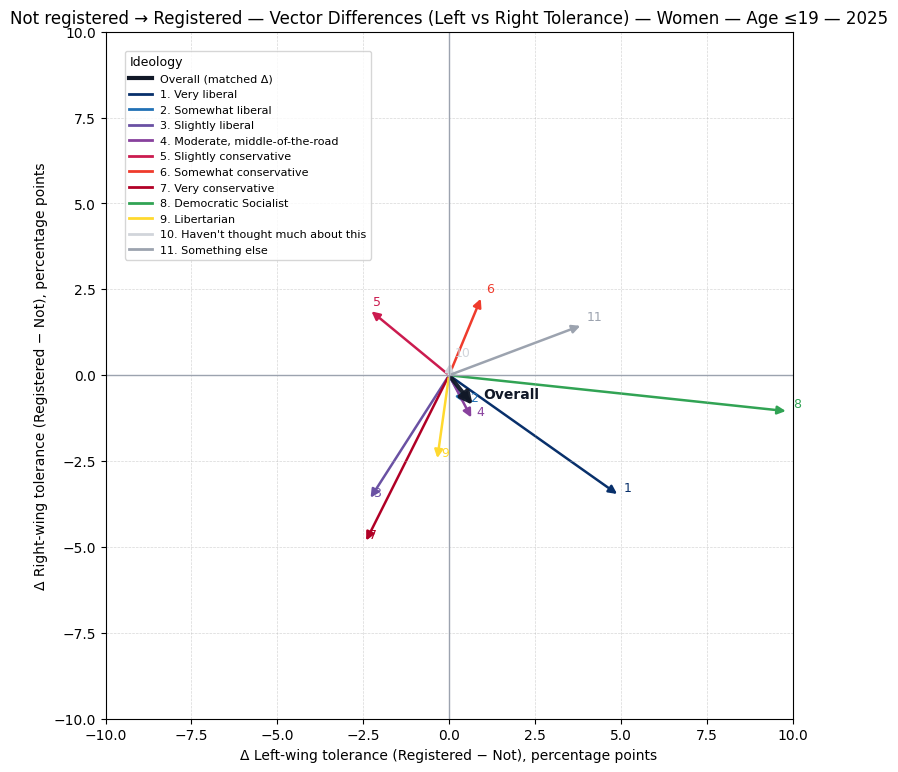

In [2]:
#!/usr/bin/env python3
"""
Vector plots comparing voter-registration groups using the Left vs Right tolerance axes.

We draw SIX square vector figures per YEAR:
  Age cohorts × Gender (Men/Women)
    1) All ages — Men:     Not registered → Registered
    2) All ages — Women:   Not registered → Registered
    3) Age ≥20 — Men:      Not registered → Registered
    4) Age ≥20 — Women:    Not registered → Registered
    5) Age ≤19 — Men:      Not registered → Registered
    6) Age ≤19 — Women:    Not registered → Registered

Each vector (per ideology) represents:
  X = Δ Left-wing tolerance (Registered − Not registered), percentage points
  Y = Δ Right-wing tolerance (Registered − Not registered), percentage points
Plus a bold pooled “Overall” arrow.

IMPORTANT (Estimator for the Overall arrow):
  This version uses the matched-delta estimator:
    • Compute per-ideology deltas only for ideologies that have BOTH registration statuses.
    • Pool deltas with weights w_i = min(n_i_base, n_i_target).
  (Replaces the old "difference of weighted means" approach.)

We also print count tables (N) by voter registration for each gender/cohort,
and the per-ideology Ns used for the deltas.

Inputs
------
- cfsrALL_24_25.csv (same as your other scripts)

Outputs
-------
- vectors_left_right_NotToRegistered_Men_AllAges_YYYY.png
- vectors_left_right_NotToRegistered_Women_AllAges_YYYY.png
- vectors_left_right_NotToRegistered_Men_Age20Plus_YYYY.png
- vectors_left_right_NotToRegistered_Women_Age20Plus_YYYY.png
- vectors_left_right_NotToRegistered_Men_Age19AndUnder_YYYY.png
- vectors_left_right_NotToRegistered_Women_Age19AndUnder_YYYY.png

Usage
-----
- Ensure cfsrALL_24_25.csv is next to this file
- Adjust YEAR if needed
- Run: python vector_plots_registration_deltas_6plots.py
"""

from pathlib import Path
from typing import Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

# ---------- Settings ----------
CSV_PATH = Path("cfsrALL_24_25.csv")
YEAR = 2025

# ---------- Labels & triads ----------
IDEO_LABELS = {
    1: "Very liberal",
    2: "Somewhat liberal",
    3: "Slightly liberal",
    4: "Moderate, middle-of-the-road",
    5: "Slightly conservative",
    6: "Somewhat conservative",
    7: "Very conservative",
    8: "Democratic Socialist",
    9: "Libertarian",
    10: "Haven't thought much about this",
    11: "Something else",
}

REGVOTER_LABELS = {
    0: "Not registered",
    1: "Registered",
}

RIGHT_TRIAD = ["spk_abortion", "spk_trans", "spk_blm"]
LEFT_TRIAD  = ["spk_cathped", "spk_policekkk", "spk_kidtrans"]
SPK_ALL = RIGHT_TRIAD + LEFT_TRIAD

# ---------- Colors (ideology-coded) ----------
def ideology_colors() -> Dict[int, str]:
    return {
        1: "#08306b",  # deep navy
        2: "#2171b5",  # blue
        3: "#6a51a3",  # strong purple
        4: "#88419d",  # mid purple
        5: "#cb1b4f",  # magenta-red
        6: "#ef3b2c",  # bright red
        7: "#b10026",  # deep red
        8: "#31a354",  # green
        9: "#ffd92f",  # yellow
        10: "#d1d5db", # light gray
        11: "#9ca3af", # darker gray
    }
IDEO_COLORS = ideology_colors()

# ---------- Helpers ----------
def scale_triad_to_pct(sum_vals: pd.Series, k: int = 3) -> pd.Series:
    """Maps triad sum (k..4k) to 0..100%."""
    return (sum_vals - k) / (3 * k) * 100.0


def build_ideo_like_code(df: pd.DataFrame) -> pd.Series:
    """Build ideology 1..11 with preference order: fire_ideo → cp_ideo → ideo."""
    to_num = lambda c: pd.to_numeric(df.get(c), errors="coerce")
    fire, cp, raw = to_num("fire_ideo"), to_num("cp_ideo"), to_num("ideo")
    valid_fire = (fire >= 1) & (fire <= 11)
    valid_cp   = (cp   >= 1) & (cp   <= 11)
    valid_raw  = (raw  >= 1) & (raw  <= 11)
    ideo = np.where(valid_fire, fire, np.where(valid_cp, cp, np.where(valid_raw, raw, np.nan)))
    return pd.Series(ideo, index=df.index).astype("Int64")


def load_and_filter(csv_path: Path, year: int, min_age: Optional[int] = None, max_age: Optional[int] = None) -> pd.DataFrame:
    """
    Load CSV, coerce numerics, build ideology, and apply filters; validate ranges.
    Optional age bounds (inclusive). If either is provided, 'age' must exist.
    """
    if not csv_path.exists():
        raise FileNotFoundError(f"Data file not found at: {csv_path.resolve()}")

    df = pd.read_csv(csv_path, low_memory=False)

    # If age filtering requested, ensure column exists and apply
    if (min_age is not None) or (max_age is not None):
        if "age" not in df.columns:
            raise ValueError("Age filter requested but 'age' column not found.")
        df["age"] = pd.to_numeric(df["age"], errors="coerce")
        if min_age is not None:
            df = df[df["age"] >= min_age]
        if max_age is not None:
            df = df[df["age"] <= max_age]
        if df.empty:
            raise ValueError(f"No rows remain after applying age filter: min_age={min_age}, max_age={max_age}.")

    # Coerce relevant columns to numeric
    for col in ["datayear", "gender_bin", "regvoter", *SPK_ALL]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Build ideology
    df["ideo"] = build_ideo_like_code(df)

    # Base filters: year, gender, ideology, regvoter (0/1)
    df = df[
        (df["datayear"] == year)
        & (df["gender_bin"].isin([1, 2]))
        & (df["regvoter"].isin([0, 1]))
        & (df["ideo"].isin(range(1, 12)))
    ].copy()
    if df.empty:
        raise ValueError(
            f"No rows after filtering for year={year}, gender in [1,2], regvoter in [0,1], and ideo in 1..11."
        )

    # Require ALL six spk_* in [1,4]
    in_range_spk = df[SPK_ALL].ge(1) & df[SPK_ALL].le(4)
    df = df[in_range_spk.all(axis=1)].copy()
    if df.empty:
        raise ValueError("No rows remain after requiring spk_* in [1,4].")

    # Triad sums & scale to percent (0..100)
    df["right_sum"] = df[RIGHT_TRIAD].sum(axis=1).astype(int)
    df["left_sum"]  = df[LEFT_TRIAD].sum(axis=1).astype(int)
    df["right_pct"] = scale_triad_to_pct(df["right_sum"], k=len(RIGHT_TRIAD))
    df["left_pct"]  = scale_triad_to_pct(df["left_sum"],  k=len(LEFT_TRIAD))

    return df


def compute_group_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group means (ideology × gender × regvoter) for left/right tolerance, with Ns.
    Returns columns: ideo, gender_bin, regvoter, left_avg, right_avg, n
    """
    stats = (
        df.groupby(["ideo", "gender_bin", "regvoter"], dropna=True)
          .agg(left_avg=("left_pct", "mean"),
               right_avg=("right_pct", "mean"),
               n=("left_pct", "size"))
          .reset_index()
    )
    return stats


def prepare_deltas_for_gender(
    stats: pd.DataFrame,
    gender_code: int,
    base_reg: int = 0,   # Not registered
    target_reg: int = 1  # Registered
) -> pd.DataFrame:
    """
    For a given gender, compute ideology-wise deltas:
      Δx = left_avg(target) − left_avg(base)
      Δy = right_avg(target) − right_avg(base)
    Keep ideologies where both groups exist.
    Also include n_base and n_target for transparency.
    """
    s = stats[stats["gender_bin"] == gender_code].copy()
    if s.empty:
        return pd.DataFrame(columns=[
            "ideo", "Ideology label", "delta_x", "delta_y", "magnitude",
            "n_base", "n_target"
        ])

    x_pivot = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    y_pivot = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_pivot = s.pivot(index="ideo", columns="regvoter", values="n")

    df = pd.DataFrame({
        "delta_x":  x_pivot.get(target_reg) - x_pivot.get(base_reg),
        "delta_y":  y_pivot.get(target_reg) - y_pivot.get(base_reg),
        "n_base":   n_pivot.get(base_reg),
        "n_target": n_pivot.get(target_reg),
    }).dropna().reset_index()

    df["ideo"] = df["ideo"].astype(int)
    df["Ideology label"] = df["ideo"].map(IDEO_LABELS)
    df["magnitude"] = np.sqrt(df["delta_x"]**2 + df["delta_y"]**2)

    return df[["ideo", "Ideology label", "delta_x", "delta_y", "magnitude", "n_base", "n_target"]].sort_values("ideo")


def compute_overall_delta_for_gender(
    stats: pd.DataFrame,
    gender_code: int,
    base_reg: int = 0,
    target_reg: int = 1
) -> dict | None:
    """
    Matched-delta overall arrow for a gender:
      • Compute per-ideology deltas only for ideologies that have BOTH reg statuses.
      • Pool deltas with weights w_i = min(n_i_base, n_i_target).
    Returns dict with delta_x, delta_y, n_base, n_target or None if unavailable.
    """
    s = stats[stats["gender_bin"] == gender_code]
    if s.empty:
        return None

    # Pivots
    x_pivot = s.pivot(index="ideo", columns="regvoter", values="left_avg")
    y_pivot = s.pivot(index="ideo", columns="regvoter", values="right_avg")
    n_pivot = s.pivot(index="ideo", columns="regvoter", values="n")

    # Need both statuses present
    for p in (x_pivot, y_pivot, n_pivot):
        if base_reg not in p.columns or target_reg not in p.columns:
            return None

    x_pair = x_pivot[[base_reg, target_reg]].dropna()
    y_pair = y_pivot[[base_reg, target_reg]].dropna()
    n_pair = n_pivot[[base_reg, target_reg]].dropna()

    common = x_pair.index.intersection(y_pair.index).intersection(n_pair.index)
    if len(common) == 0:
        return None

    dx = (x_pair.loc[common, target_reg] - x_pair.loc[common, base_reg]).astype(float)
    dy = (y_pair.loc[common, target_reg] - y_pair.loc[common, base_reg]).astype(float)
    w  = np.minimum(n_pair.loc[common, base_reg], n_pair.loc[common, target_reg]).astype(float)

    mask = (w > 0) & dx.notna() & dy.notna()
    if not mask.any():
        return None

    sel = w.index[mask]
    delta_x = float(np.average(dx.loc[sel], weights=w.loc[sel]))
    delta_y = float(np.average(dy.loc[sel], weights=w.loc[sel]))

    return {
        "delta_x":  delta_x,
        "delta_y":  delta_y,
        "n_base":   int(n_pair.loc[sel, base_reg].sum()),
        "n_target": int(n_pair.loc[sel, target_reg].sum()),
    }


def plot_vectors_for_gender(
    df_deltas: pd.DataFrame,
    pair_label: str,
    gender_label: str,
    year: int,
    save_path: Path | None = None,
    overall_delta: dict | None = None,
):
    """
    Square figure; ideology-colored vectors from origin.
    X = Δ Left-wing tolerance ; Y = Δ Right-wing tolerance
    """
    fig, ax = plt.subplots(figsize=(8, 8))  # KEEP SIZE

    # Crosshairs at origin
    ax.axhline(0, linewidth=1.0, color="#9ca3af")
    ax.axvline(0, linewidth=1.0, color="#9ca3af")

    # One vector per ideology (color-coded)
    for _, r in df_deltas.iterrows():
        i = int(r["ideo"])
        color = IDEO_COLORS.get(i, "#9ca3af")
        dx = float(r["delta_x"])
        dy = float(r["delta_y"])
        # Dashed if effective N (min of base/target) < 40
        n_base = float(r["n_base"]) if not pd.isna(r["n_base"]) else np.nan
        n_target = float(r["n_target"]) if not pd.isna(r["n_target"]) else np.nan
        n_eff = np.nanmin([n_base, n_target])
        ls = "--" if (not np.isnan(n_eff) and n_eff < 40) else "-"
        ax.add_patch(FancyArrowPatch((0.0, 0.0), (dx, dy),
                                     arrowstyle="-|>", mutation_scale=12, linewidth=1.8,
                                     color=color, linestyle=ls))
        ax.annotate(str(i), xy=(dx, dy), xytext=(3, 3),
                    textcoords="offset points", fontsize=9, color=color)

    # Pooled "Overall" arrow (thicker, dark) — now "matched Δ"
    overall_handle = None
    if overall_delta is not None:
        odx = float(overall_delta["delta_x"])
        ody = float(overall_delta["delta_y"])
        n_eff_overall = min(overall_delta["n_base"], overall_delta["n_target"])
        ls_overall = "--" if n_eff_overall < 40 else "-"
        ax.add_patch(FancyArrowPatch(
            (0.0, 0.0), (odx, ody),
            arrowstyle="-|>", mutation_scale=18, linewidth=3.0,
            color="#111827", linestyle=ls_overall, alpha=0.95
        ))
        ax.annotate("Overall", xy=(odx, ody), xytext=(6, 6),
                    textcoords="offset points", fontsize=10, color="#111827",
                    fontweight="bold")
        overall_handle = Line2D([0],[0], color="#111827", lw=3, label="Overall (matched Δ)")

    # Fixed symmetric limits for quick comparability
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_aspect("equal")

    ax.set_xlabel("Δ Left-wing tolerance (Registered − Not), percentage points")
    ax.set_ylabel("Δ Right-wing tolerance (Registered − Not), percentage points")
    ax.set_title(f"{pair_label} — Vector Differences (Left vs Right Tolerance) — {gender_label} — {year}")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Legend (TOP-LEFT) — include Overall if available
    handles = []
    if overall_handle is not None:
        handles.append(overall_handle)
    handles.extend([Line2D([0],[0], color=IDEO_COLORS[i], lw=2, label=f"{i}. {IDEO_LABELS[i]}") for i in range(1, 12)])
    leg = ax.legend(
        handles=handles,
        title="Ideology",
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fontsize=8,
        title_fontsize=9,
        frameon=True,
        borderaxespad=0.5,
    )
    try:
        leg._legend_box.align = "left"
    except Exception:
        pass

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=150)
        print(f"Saved: {save_path}")
    plt.show()


def print_reg_counts_table(df: pd.DataFrame, gender_code: int, cohort_label: str):
    label = "Men" if gender_code == 1 else "Women"
    counts = (
        df.loc[df["gender_bin"] == gender_code, "regvoter"]
          .value_counts()
          .reindex([0, 1], fill_value=0)
          .rename(index=REGVOTER_LABELS)
    )
    out = counts.reset_index()
    out.columns = ["Registration status", "N"]
    print(f"\nSample size by registration — {label} — {cohort_label}")
    print(out.to_string(index=False))


def run_for_cohort(cohort_name: str, cohort_suffix: str, min_age: Optional[int], max_age: Optional[int]):
    """
    Build plots for a single cohort (age bounds), for both genders.
    """
    print(f"\n=== Cohort: {cohort_name} (min_age={min_age}, max_age={max_age}) ===")
    df = load_and_filter(CSV_PATH, YEAR, min_age=min_age, max_age=max_age)
    stats = compute_group_means(df)

    pair_label = "Not registered → Registered"

    # --- MEN ---
    men_label = f"Men — {cohort_name}"
    print_reg_counts_table(df, gender_code=1, cohort_label=cohort_name)

    men_deltas = prepare_deltas_for_gender(stats, gender_code=1, base_reg=0, target_reg=1)
    men_overall = compute_overall_delta_for_gender(stats, gender_code=1, base_reg=0, target_reg=1)
    if men_deltas.empty:
        print(f"No data for Men ({cohort_name}) after filtering.")
    else:
        try:
            from IPython.display import display
            print(f"\nΔ (Left, Right) — Men — {cohort_name} — Not registered → Registered")
            display(men_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}))
        except Exception:
            print(f"\nΔ (Left, Right) — Men — {cohort_name} — Not registered → Registered")
            print(men_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}).to_string(index=False))
        plot_vectors_for_gender(
            men_deltas,
            pair_label=pair_label,
            gender_label=men_label,
            year=YEAR,
            save_path=Path(f"vectors_left_right_NotToRegistered_Men_{cohort_suffix}_{YEAR}.png"),
            overall_delta=men_overall,
        )

    # --- WOMEN ---
    women_label = f"Women — {cohort_name}"
    print_reg_counts_table(df, gender_code=2, cohort_label=cohort_name)

    women_deltas = prepare_deltas_for_gender(stats, gender_code=2, base_reg=0, target_reg=1)
    women_overall = compute_overall_delta_for_gender(stats, gender_code=2, base_reg=0, target_reg=1)
    if women_deltas.empty:
        print(f"No data for Women ({cohort_name}) after filtering.")
    else:
        try:
            from IPython.display import display
            print(f"\nΔ (Left, Right) — Women — {cohort_name} — Not registered → Registered")
            display(women_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}))
        except Exception:
            print(f"\nΔ (Left, Right) — Women — {cohort_name} — Not registered → Registered")
            print(women_deltas.round({"delta_x": 2, "delta_y": 2, "magnitude": 2}).to_string(index=False))
        plot_vectors_for_gender(
            women_deltas,
            pair_label=pair_label,
            gender_label=women_label,
            year=YEAR,
            save_path=Path(f"vectors_left_right_NotToRegistered_Women_{cohort_suffix}_{YEAR}.png"),
            overall_delta=women_overall,
        )


def main():
    # Run 3 cohorts × 2 genders = 6 plots
    cohorts = [
        ("All ages",        "AllAges",        None, None),
        ("Age ≥20",         "Age20Plus",      20,   None),
        ("Age ≤19",         "Age19AndUnder",  None, 19),
    ]
    for name, suffix, min_age, max_age in cohorts:
        try:
            run_for_cohort(name, suffix, min_age, max_age)
        except Exception as e:
            print(f"Error in cohort '{name}': {e}")


if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error while processing: {e}")
